In [2]:
import pandas as pd
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.ndimage


# Load data from zip file
zip_path = "data/dmc_122124.zip"
zip_path = "data/dmc_122724.zip"
records = []

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    for filename in zip_ref.namelist():
        if filename.endswith('.npy'):
            # Extract parameters from directory name (e.g. BRO_64_1_3e-4)
            env_name = filename.split('/')[2].split('.')[0]  # Get environment name from path
            name = filename.split('/')[1]
            params = name.split('_')
            batch_size = int(params[1])
            utd = int(params[2])
            learning_rate = float(params[3])
            # Load array data
            with zip_ref.open(filename) as f:
                arr = np.load(f)
                
            # Create record with metadata and results
            records.append({
                'env_name': env_name,
                'batch_size': batch_size,
                'utd': utd,
                'learning_rate': learning_rate,
                'training_step': arr[:, 0],
                'return': arr[:, 1:],
                'mean_return': np.mean(arr[:, 1:], axis=1),  # Add summary statistics
                # 'mean_return': arr[:, 1],
                'std_return': np.std(arr[:, 1:], axis=1) / np.sqrt(10)  # Standard Error of Mean over 10 seeds
            })

# Convert to pandas DataFrame
df = pd.DataFrame(records)

smoothing = {('dog-stand', 1): 30, ('reacher-easy', 1): 10, ('hopper-stand', 1): 30, ('finger-spin', 1): 10, ('quadruped-walk', 1): 30,
             ('dog-stand', 8): 30, ('reacher-easy', 8): 10, ('hopper-stand', 8): 20, ('finger-spin', 8): 5, ('quadruped-walk', 8): 15}

# Calculate crossings for each threshold and store in array
thresholds = [100, 200, 300, 400, 500, 600, 700, 800]
# crossings_array = []
# for _, row in df.iterrows():
#     row_crossings = []
#     for threshold in thresholds:
#         # Find indices where mean return crosses the threshold
#         crossing_idx = np.mean(np.where(np.diff(np.signbit(np.array(row['mean_return']) - threshold))), axis=1).astype(int)
#         # Convert index to training step value
#         if crossing_idx >= 0:
#             crossing_step = row['training_step'][crossing_idx[0]]
#             row_crossings.append(crossing_step)
#         else:
#             row_crossings.append(np.nan)
#     crossings_array.append(row_crossings)
# df['crossings'] = crossings_array

crossings_array = []
crossings_sem_array = []
for _, row in df.iterrows():
    row_crossings = []
    row_crossings_sem = []
    for threshold in thresholds:
        # Find indices where each seed's return crosses the threshold
        seed_crossings = []
        for seed_returns in row['return'].T:  # Transpose to iterate over seeds
            # smooth_returns = scipy.ndimage.gaussian_filter1d(seed_returns, smoothing[row['env_name'], row['utd']])
            smooth_returns = scipy.ndimage.gaussian_filter1d(seed_returns, 5)
            crossing_idx = np.median(np.where(np.diff(np.signbit(smooth_returns - threshold))), axis=1).astype(int)
            # crossing_idx = np.median(np.where(np.diff(np.signbit(np.array(row['mean_return']) - threshold))), axis=1).astype(int) # note - this is sensitive to noise, use crossings after averaging
            seed_crossings.append(row['training_step'][crossing_idx][0] if crossing_idx > 0 else np.nan)

        # Calculate mean and standard error of crossing points across seeds
        seed_crossings = np.array(seed_crossings)
        sem_crossing = np.nanstd(seed_crossings) / np.sqrt(np.sum(~np.isnan(seed_crossings))) if np.sum(~np.isnan(seed_crossings)) > 1 else np.nan
        row_crossings_sem.append(sem_crossing)

        # get mean separately
        # mean_crossing = seed_crossings[0]
        # mean_crossing = np.median(seed_crossings)
        # row_crossings.append(mean_crossing)
        mean_crossing_idx = np.median(np.where(np.diff(np.signbit(np.array(row['mean_return']) - threshold))), axis=1).astype(int) # note - this is sensitive to noise, use crossings after averaging
        row_crossings.append(row['training_step'][mean_crossing_idx][0] if mean_crossing_idx > 0 else np.nan)
    
    crossings_array.append(row_crossings)
    crossings_sem_array.append(row_crossings_sem)

df['crossings'] = crossings_array
df['crossings_sem'] = crossings_sem_array
df

/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


env_name  batch_size  utd  learning_rate  \
0         dog-stand          64    8        0.00015   
1      reacher-easy          64    8        0.00015   
2      hopper-stand          64    8        0.00015   
3       finger-spin          64    8        0.00015   
4    quadruped-walk          64    8        0.00015   
..              ...         ...  ...            ...   
115       dog-stand         256    1        0.00030   
116    reacher-easy         256    1        0.00030   
117    hopper-stand         256    1        0.00030   
118     finger-spin         256    1        0.00030   
119  quadruped-walk         256    1        0.00030   

                                         training_step  \
0    [5000.0, 6000.0, 7000.0, 8000.0, 9000.0, 10000...   
1    [5000, 6000, 7000, 8000, 9000, 10000, 11000, 1...   
2    [5000.0, 6000.0, 7000.0, 8000.0, 9000.0, 10000...   
3    [5000, 6000, 7000, 8000, 9000, 10000, 11000, 1...   
4    [5000.0, 6000.0, 7000.0, 8000.0, 9000.0, 10000...   
..                                                 ...   
115  [5000.0, 6000.0, 7000.0, 8000.0, 9000.0, 10000...   
116  [5000, 6000, 7000, 8000, 9000, 10000, 11000, 1...   
117  [5000.0, 6000.0, 7000.0, 8000.0, 9000.0, 10000...   
118  [5000, 6000, 7000, 8000, 9000, 10000, 11000, 1...   
119  [5000.0, 6000.0, 7000.0, 8000.0, 9000.0, 10000...   

                                                return  \
0    [[0.012786157760283771, 0.008792589896180762, ...   
1    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [119, 0, 303,...   
2    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
3    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, ...   
4    [[0.9019667793428906, 0.0012992603305187961, 0...   
..                                                 ...   
115  [[0.0025101940236721015, 0.01228352635781535, ...   
116  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [57, 218, 67,...   
117  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
118  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 4, 0, 0, ...   
119  [[0.26342937675842165, 0.002848800478372198, 0...   

                                           mean_return  \
0    [0.009076612890084036, 20.560380677249054, 20....   
1    [0.0, 111.2, 212.1, 255.3, 577.6, 126.6, 197.1...   
2    [0.0, 1.0712729879328584, 2.4090577922881935, ...   
3    [0.0, 1.0, 0.7, 1.1, 13.7, 16.8, 37.7, 84.4, 1...   
4    [0.297271077197421, 257.3430544775937, 113.387...   
..                                                 ...   
115  [0.008199603641316583, 21.80759596732161, 19.1...   
116  [0.0, 50.7, 116.8, 164.4, 71.4, 32.2, 169.0, 2...   
117  [0.0, 0.8106233921928364, 1.6686003410130124, ...   
118  [0.0, 0.9, 0.1, 0.9, 0.3, 0.9, 1.6, 0.1, 0.1, ...   
119  [0.137129527302547, 203.86636663674562, 108.14...   

                                            std_return  \
0    [0.0023219206751776598, 1.3897536796960757, 1....   
1    [0.0, 65.69745809390191, 101.81114379084443, 1...   
2    [0.0, 1.0162987913045725, 1.6042998125899615, ...   
3    [0.0, 0.565685424949238, 0.2846049894151541, 0...   
4    [0.12631542565691756, 79.7073005048898, 64.046...   
..                                                 ...   
115  [0.0027724402979911996, 1.29945546909247, 0.94...   
116  [0.0, 21.015732202328802, 53.89022174754897, 8...   
117  [0.0, 0.7690248731823952, 1.0641777507083656, ...   
118  [0.0, 0.498998997994986, 0.09486832980505139, ...   
119  [0.0763923063607585, 76.1726443827881, 61.0368...   

                                             crossings  \
0    [46000.0, 88000.0, 125000.0, 171000.0, 205000....   
1    [nan, 9000, 11000, 11000, 9000, 20000, 24000, ...   
2    [47000.0, 55000.0, 64000.0, 65000.0, 84000.0, ...   
3    [12000, 13000, 16000, 18000, 20000, 25000, 310...   
4    [13000.0, 25000.0, 38000.0, 46000.0, 51000.0, ...   
..                                                 ...   
115  [76000.0, 149000.0, 191000.0, 225000.0, 264000...   
116  [8000, 18000, 16000, 26000, 29000, 35000, 5300...   
117  [84000.0, 102000.0, 115000.0, 13100

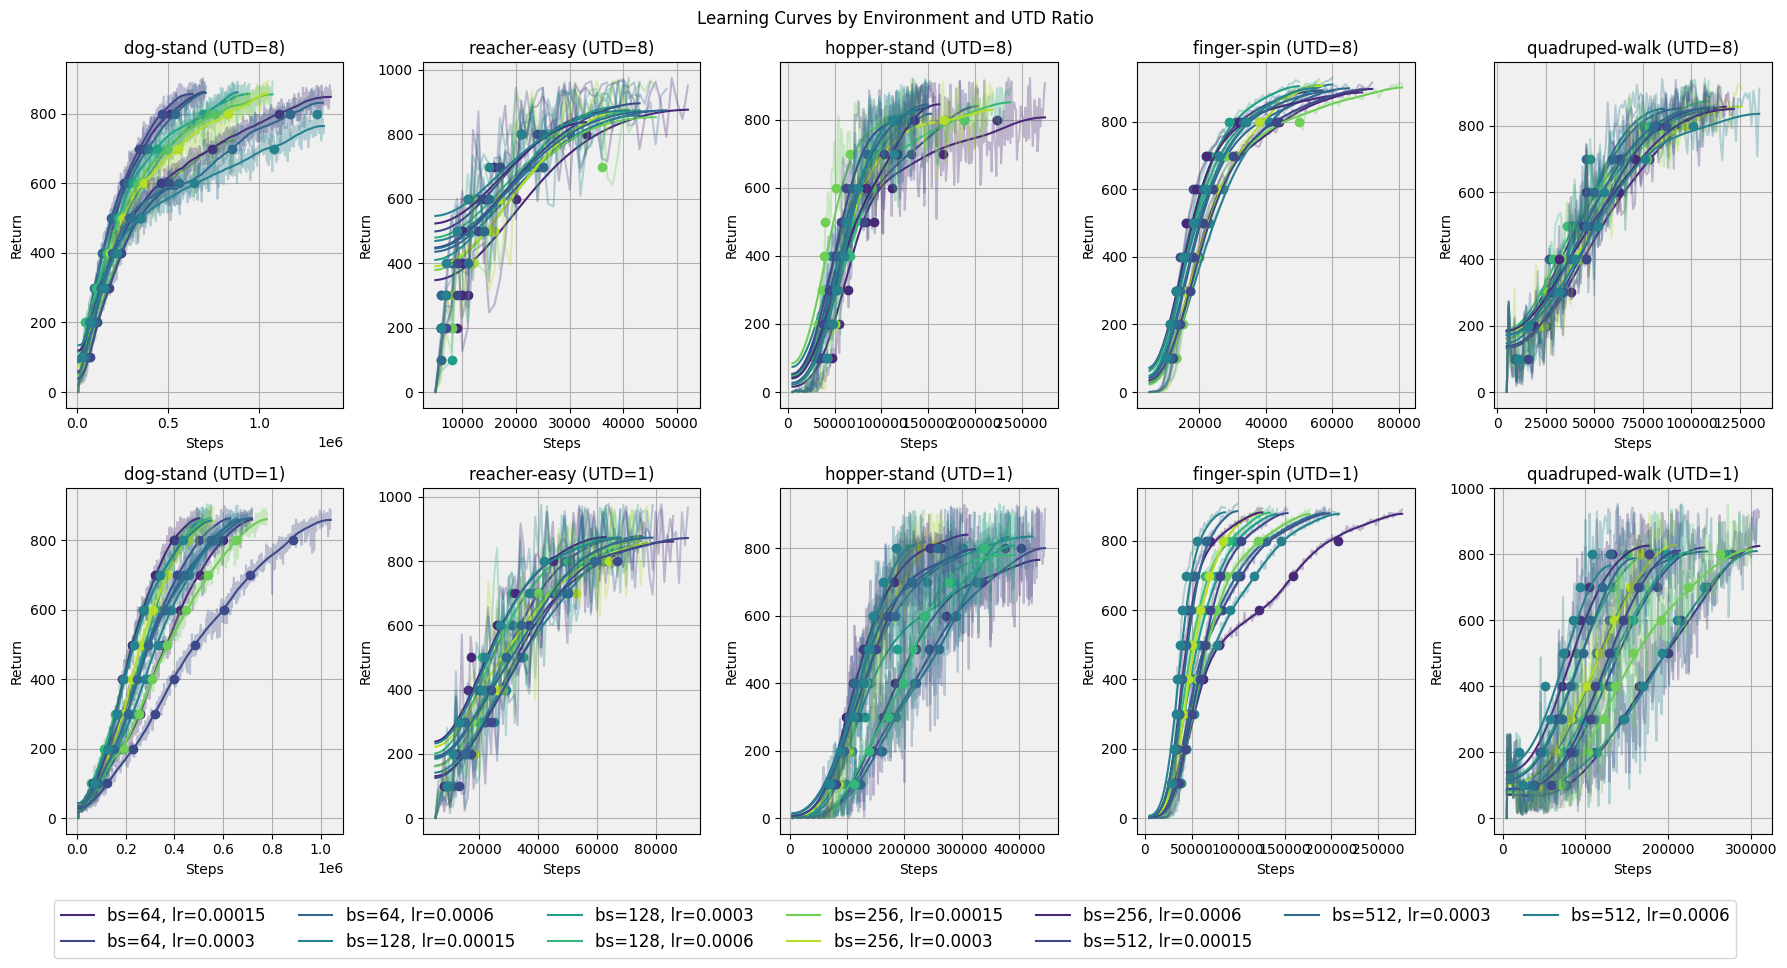

In [3]:
# plot curves

colors = sns.color_palette("viridis", n_colors=8)  # Using viridis for a nice gradient
fig, axs = plt.subplots(2, 5, figsize=(18, 9))
fig.suptitle('Learning Curves by Environment and UTD Ratio')

lines = []
labels = []
config_colors = {}
color_idx = 0

df_filtered = df[df['batch_size'] == 64]
df_filtered = df
# df_filtered = df_filtered[df_filtered['learning_rate'] == 3e-4]

# Group data by environment and UTD ratio
for i, env in enumerate(df['env_name'].unique()):
    env_data = df_filtered[df_filtered['env_name'] == env]
    
    # Create separate plots for each UTD value
    for j, utd in enumerate(env_data['utd'].unique()):
        utd_data = env_data[env_data['utd'] == utd]
        # Sort by batch size and learning rate
        utd_data = utd_data.sort_values(['utd', 'batch_size', 'learning_rate'])
        
        ax = axs[j, i]
        ax.set_title(f'{env} (UTD={utd})')
        
        for _, row in utd_data.iterrows():
            config = (row['batch_size'], row['learning_rate'])
            if config not in config_colors:
                config_colors[config] = color_idx
                color_idx += 1
            
            label = f"bs={row['batch_size']}, lr={row['learning_rate']}"
            line = ax.plot(row['training_step'], row['mean_return'], alpha=0.3, color=colors[config_colors[config] % len(colors)])
            results = scipy.ndimage.gaussian_filter1d(row['mean_return'], smoothing[env, row['utd']])
            line = ax.plot(row['training_step'], results, alpha=1, color=colors[config_colors[config] % len(colors)])

            # use the crossings column to plot crossings
            for k, threshold in enumerate(thresholds):
                crossing_x = row['crossings'][k]
                crossing_y = threshold
                ax.plot(crossing_x, crossing_y, 'o', color=colors[config_colors[config] % len(colors)])
            
            # Only add to legend if we haven't seen this combination before
            if label not in labels:
                lines.append(line[0])
                labels.append(label)
        
        ax.set_xlabel('Steps')
        ax.set_ylabel('Return')
        ax.grid(True)
        
        # Set background color
        ax.set_facecolor('#f0f0f0')

# Sort labels by batch size and learning rate
sorted_indices = [i for i, _ in sorted(enumerate(labels), 
                                     key=lambda x: tuple(map(float, x[1].replace("bs=","").replace("lr=","").split(", "))))]
lines = [lines[i] for i in sorted_indices]
labels = [labels[i] for i in sorted_indices]

# Create a single legend outside all subplots
fig.legend(lines, labels, bbox_to_anchor=(0.5, 0), loc='upper center', ncol=(len(labels) // 2)+1, fontsize=12)
plt.tight_layout()
plt.show()

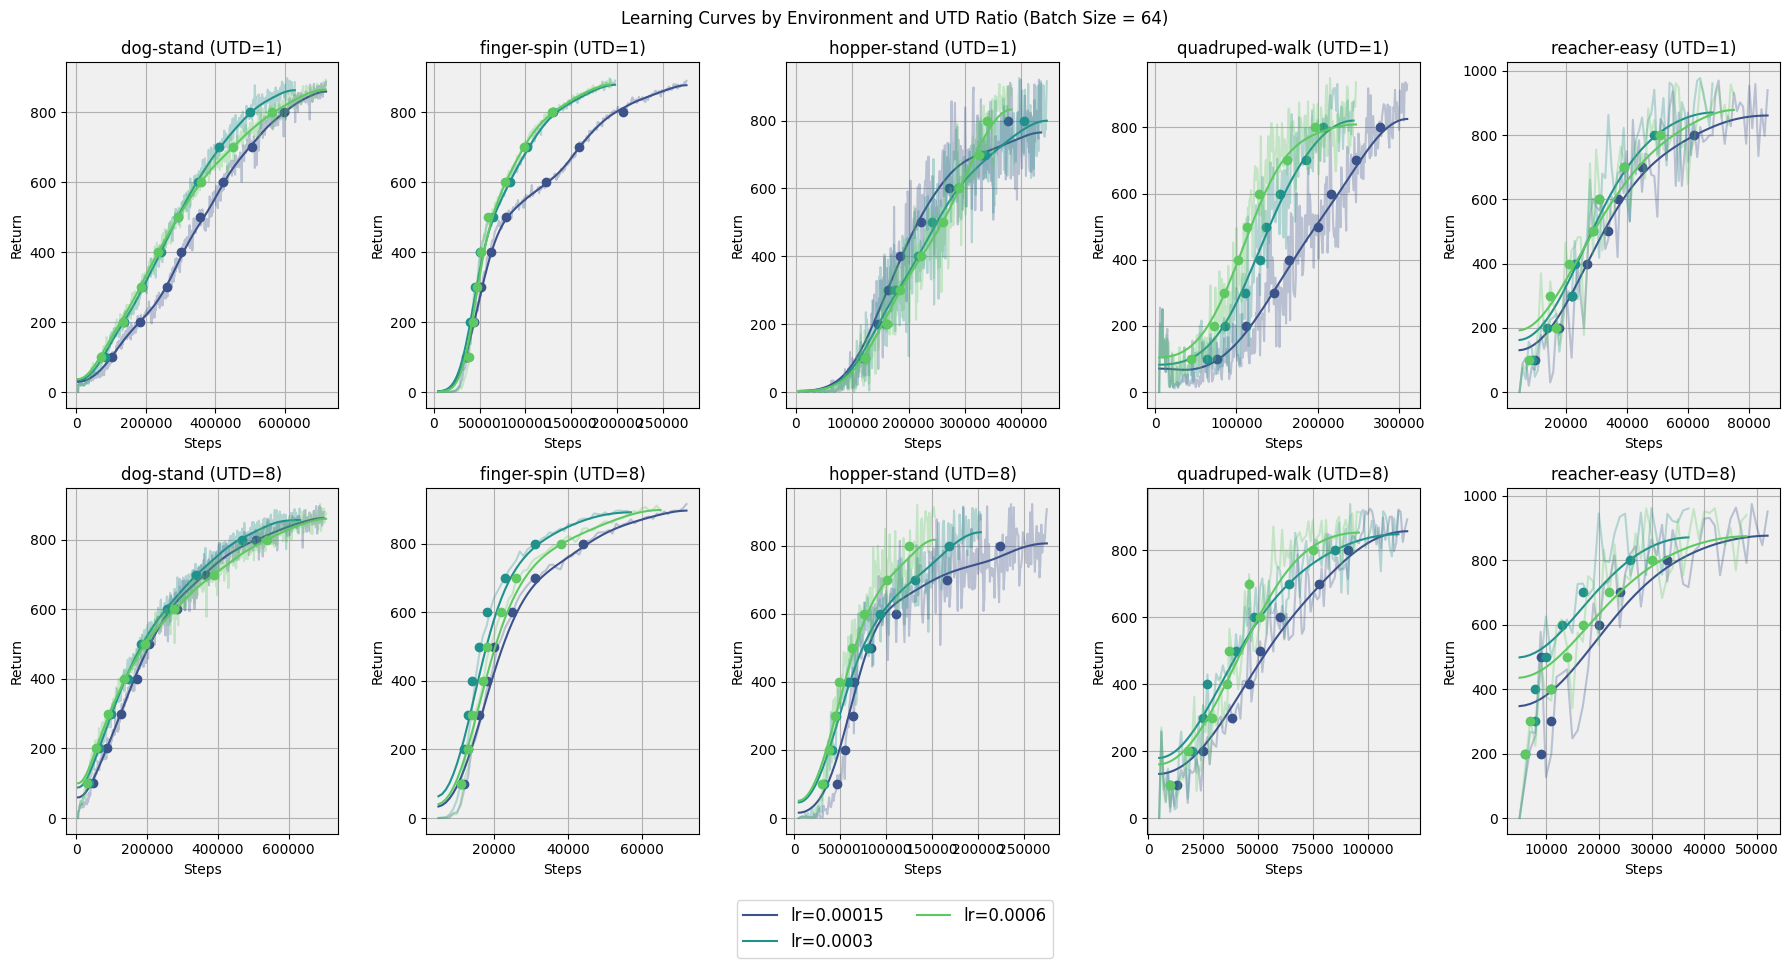

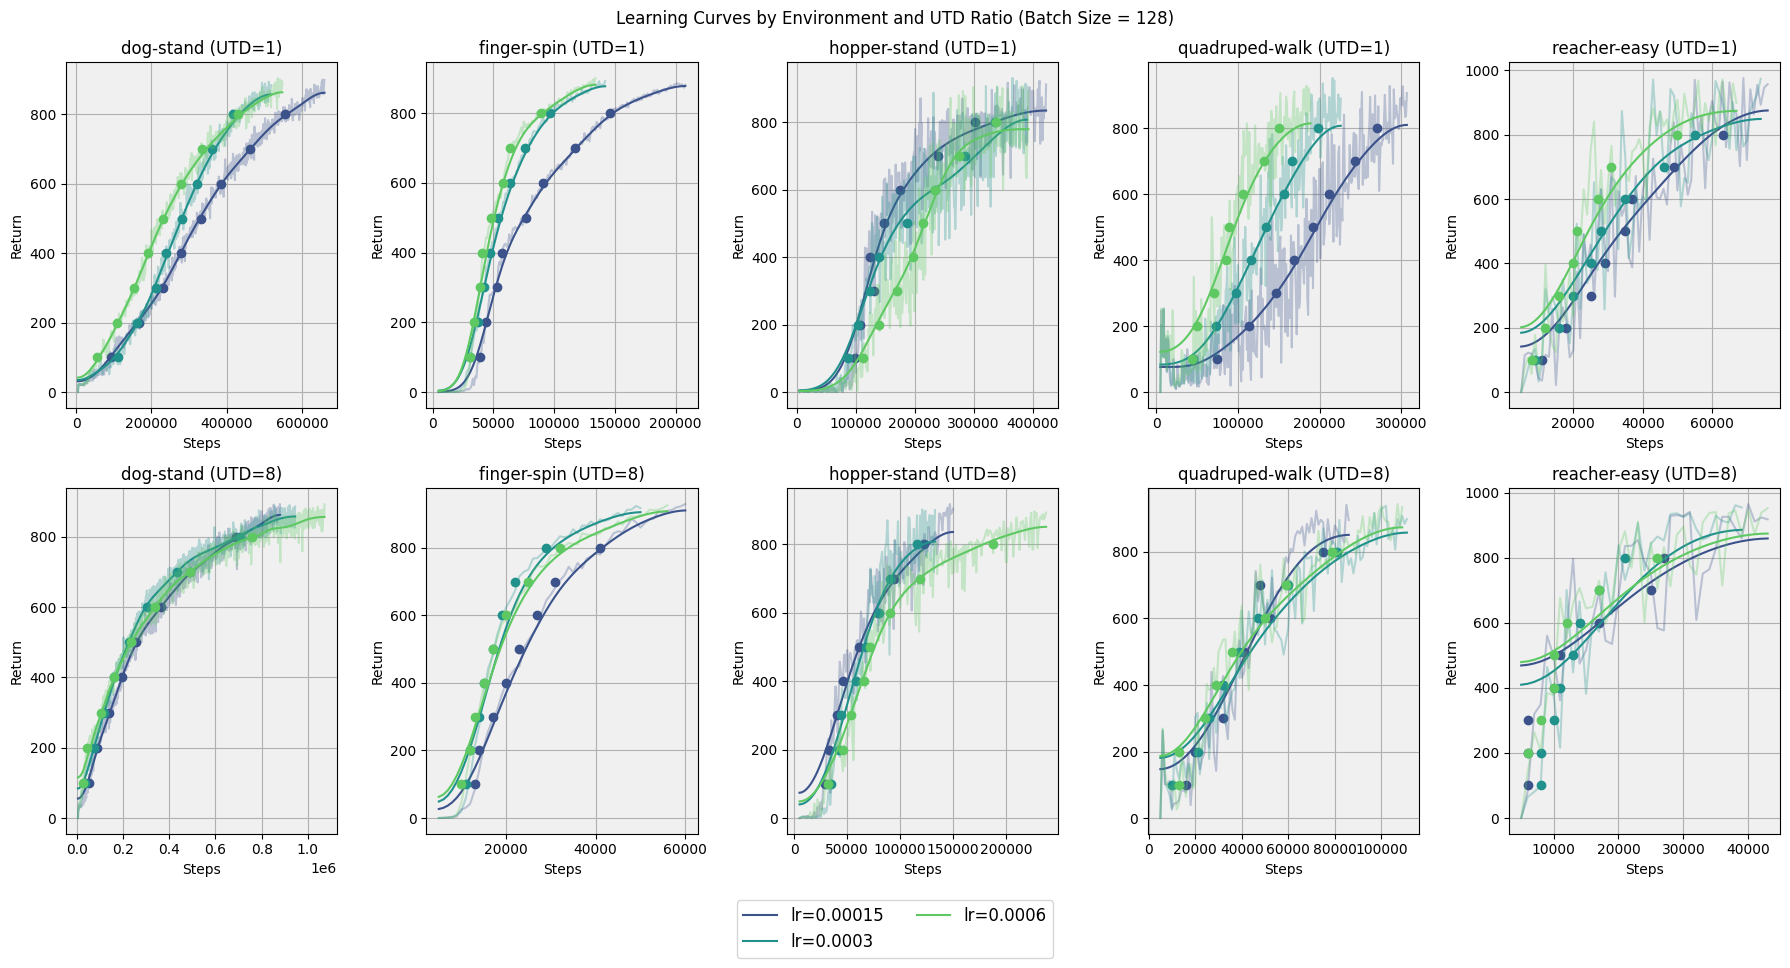

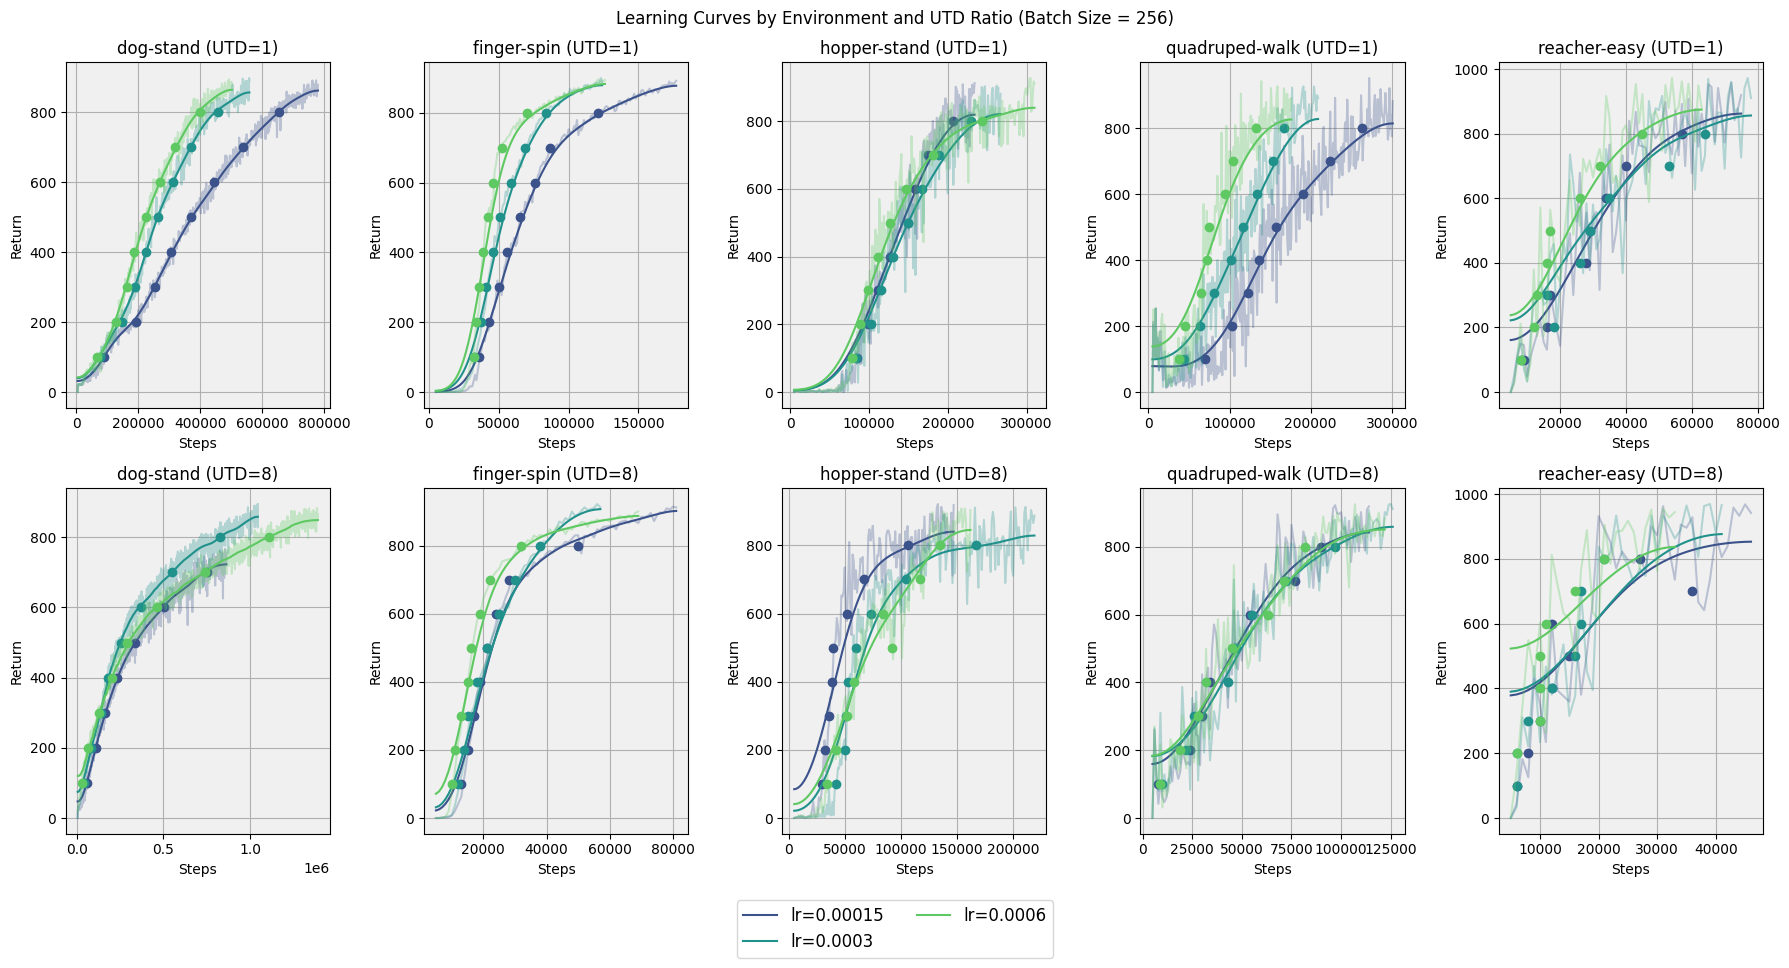

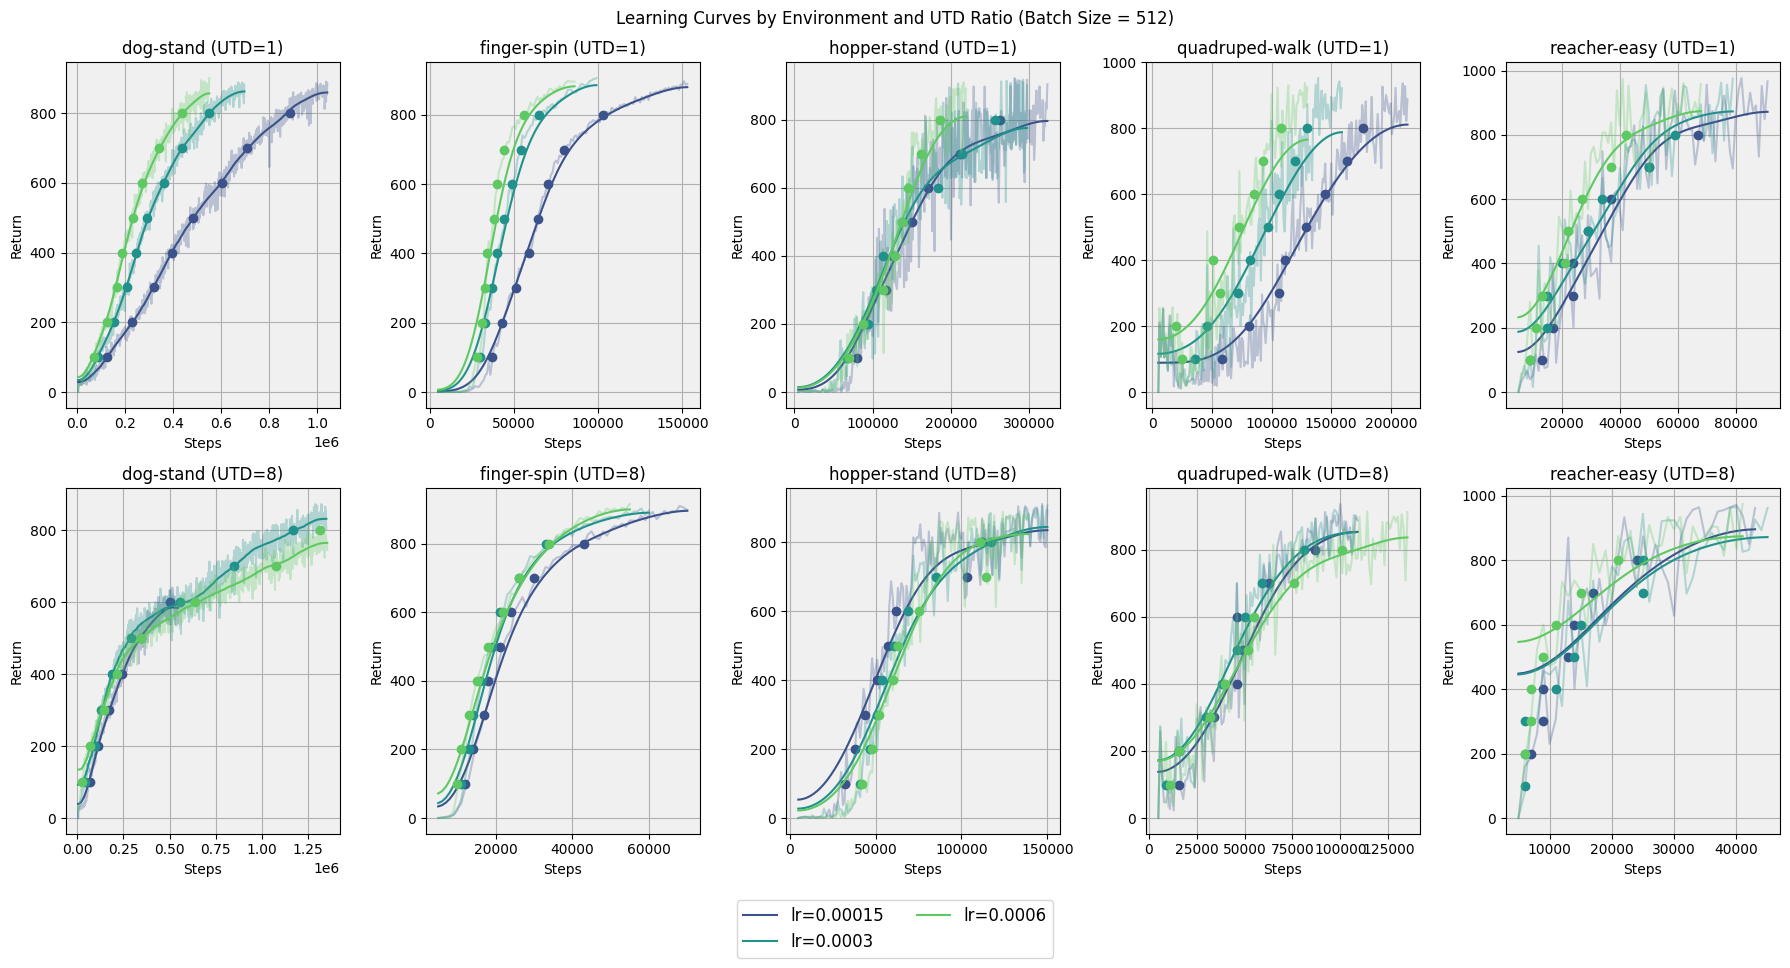

In [31]:
# plot curves

import matplotlib.pyplot as plt
import seaborn as sns

# Get unique batch sizes
batch_sizes = sorted(df['batch_size'].unique())

# Create a separate plot for each batch size
for batch_size in batch_sizes:
    colors = sns.color_palette("viridis", n_colors=3)  # Using viridis for a nice gradient
    fig, axs = plt.subplots(2, 5, figsize=(18, 9))
    fig.suptitle(f'Learning Curves by Environment and UTD Ratio (Batch Size = {batch_size})')

    lines = []
    labels = []
    config_colors = {}
    color_idx = 0

    # Filter data for current batch size
    df_filtered = df[df['batch_size'] == batch_size]

    # Group data by environment and UTD ratio
    for i, env in enumerate(sorted(df['env_name'].unique())):
        env_data = df_filtered[df_filtered['env_name'] == env]
        
        # Create separate plots for each UTD value
        for j, utd in enumerate(sorted(env_data['utd'].unique())):
            utd_data = env_data[env_data['utd'] == utd]
            # Sort by learning rate only since we're already filtering by UTD
            utd_data = utd_data.sort_values('learning_rate')
            
            ax = axs[j, i]
            ax.set_title(f'{env} (UTD={utd})')
            
            for _, row in utd_data.iterrows():
                config = row['learning_rate']
                if config not in config_colors:
                    config_colors[config] = color_idx
                    color_idx += 1
                
                label = f"lr={row['learning_rate']}"
                line = ax.plot(row['training_step'], row['mean_return'], alpha=0.3, color=colors[config_colors[config] % len(colors)])
                results = scipy.ndimage.gaussian_filter1d(row['mean_return'], smoothing[env, row['utd']])
                line = ax.plot(row['training_step'], results, alpha=1, color=colors[config_colors[config] % len(colors)])
                
                # use the crossings column to plot crossings
                for k, threshold in enumerate(thresholds):
                    crossing_x = row['crossings'][k]
                    crossing_y = threshold
                    ax.plot(crossing_x, crossing_y, 'o', color=colors[config_colors[config] % len(colors)])

                # Only add to legend if we haven't seen this combination before
                if label not in labels:
                    lines.append(line[0])
                    labels.append(label)
            
            ax.set_xlabel('Steps')
            ax.set_ylabel('Return')
            ax.grid(True)
            
            # Set background color
            ax.set_facecolor('#f0f0f0')

    # Sort labels by learning rate
    sorted_indices = [i for i, _ in sorted(enumerate(labels), 
                                         key=lambda x: float(x[1].replace("lr=","")))]
    lines = [lines[i] for i in sorted_indices]
    labels = [labels[i] for i in sorted_indices]

    # Create a single legend outside all subplots
    fig.legend(lines, labels, bbox_to_anchor=(0.5, 0), loc='upper center', ncol=(len(labels) // 2)+1, fontsize=12)
    plt.tight_layout()
    plt.show()

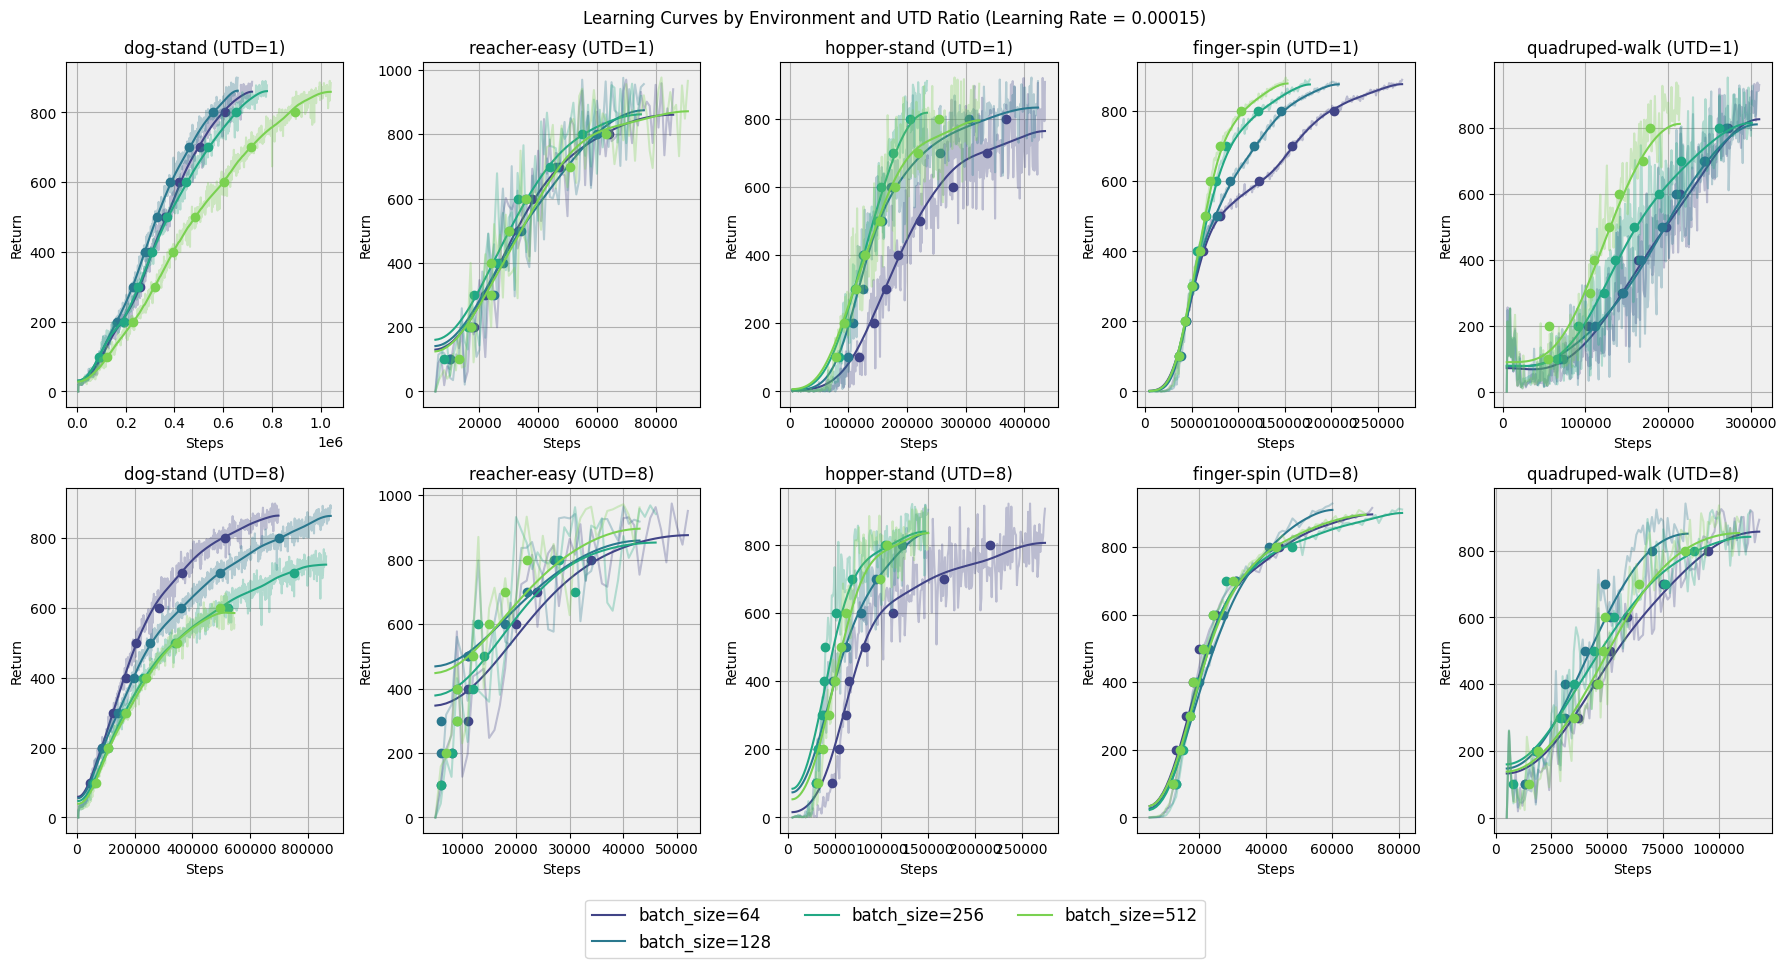

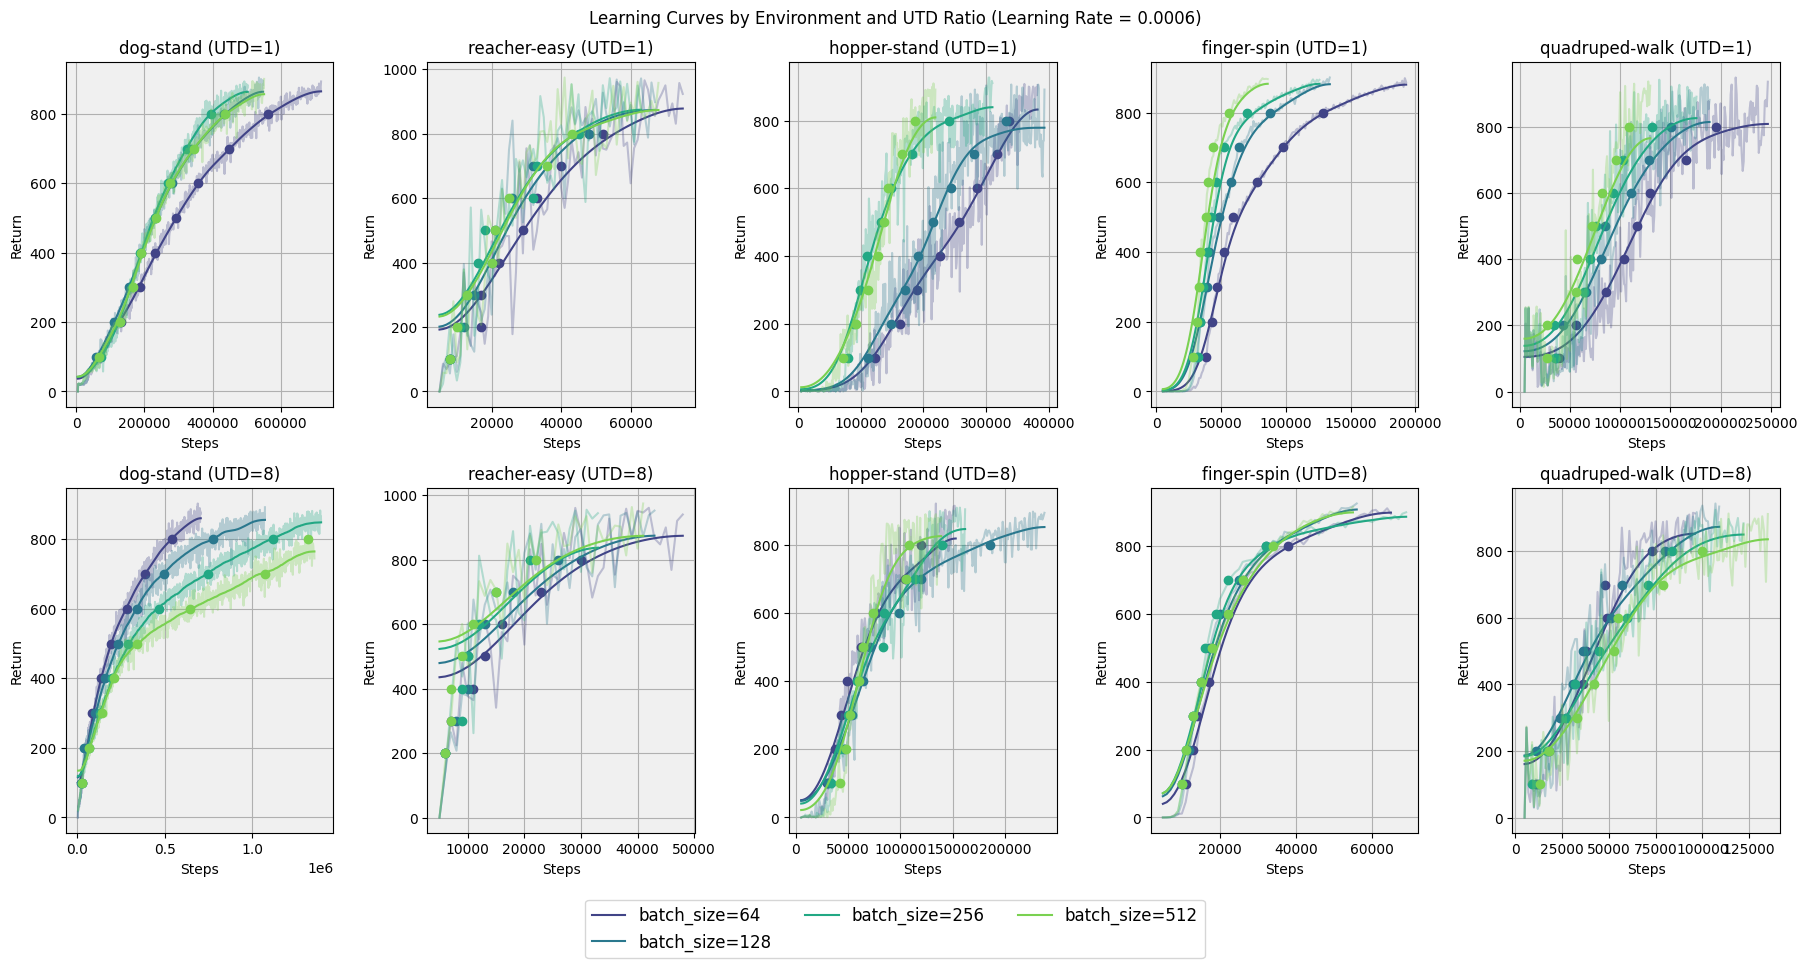

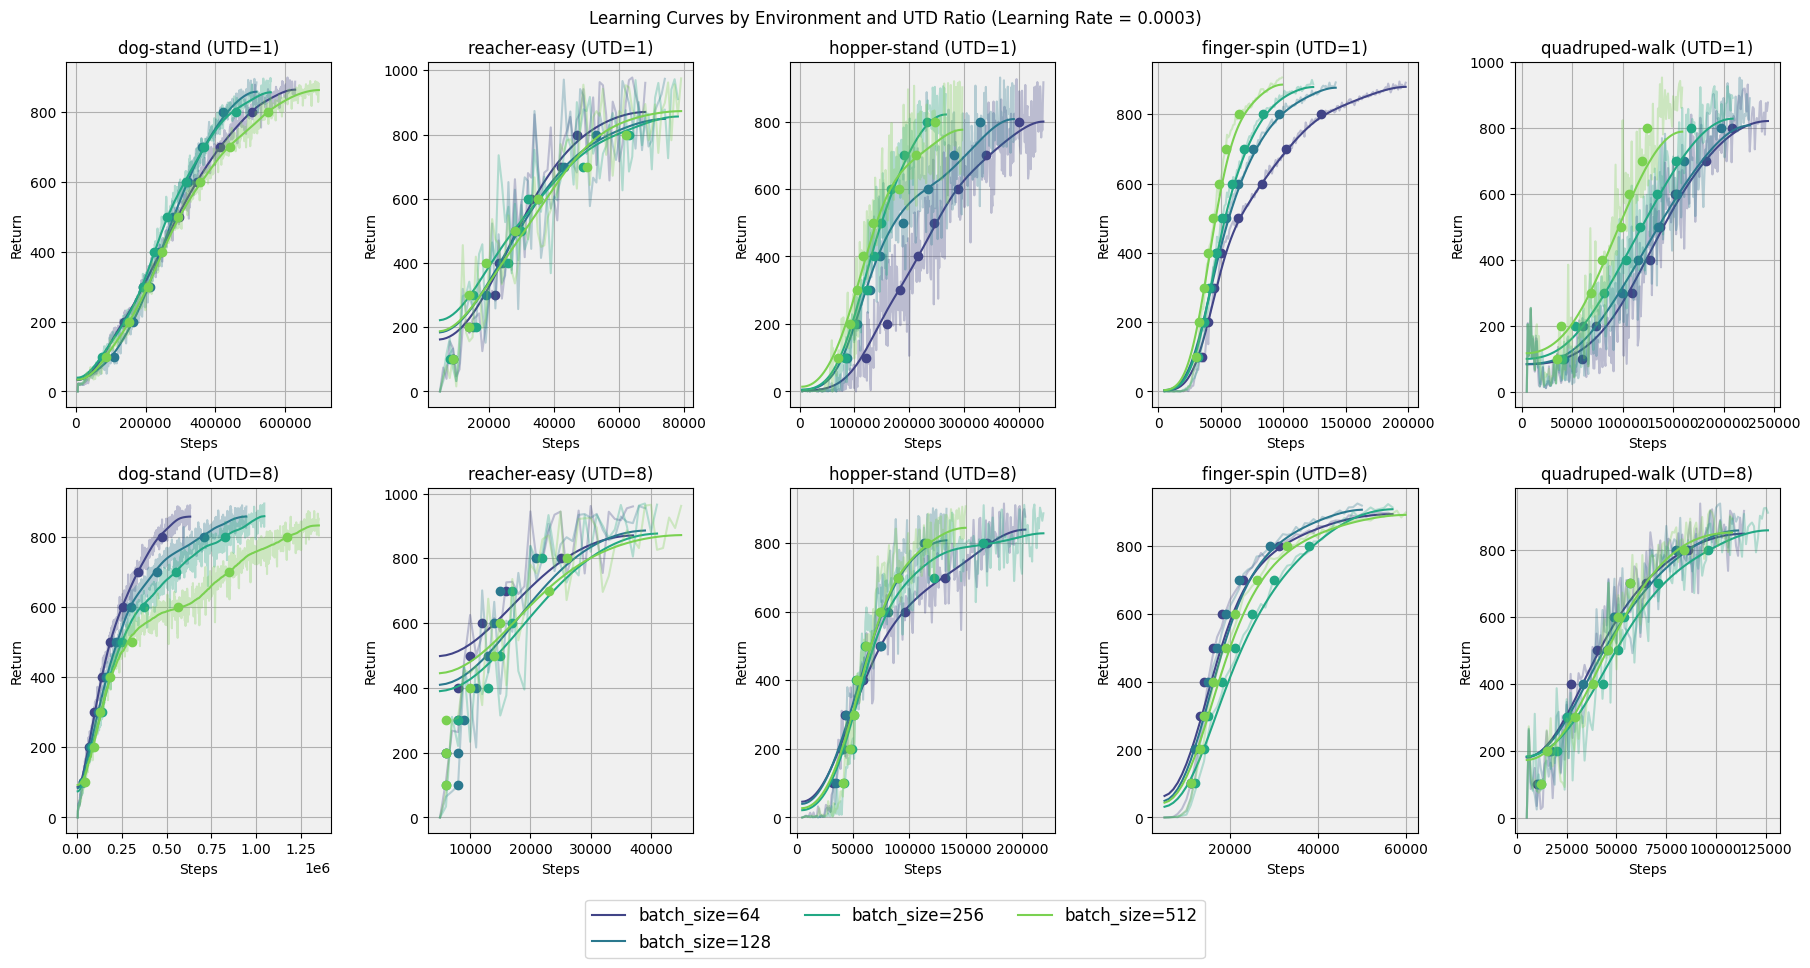

In [5]:
# plot curves

import matplotlib.pyplot as plt
import seaborn as sns

# Get unique learning rates
learning_rates = df['learning_rate'].unique()

# Create a separate plot for each learning rate
for lr in learning_rates:
    colors = sns.color_palette("viridis", n_colors=4)  # Using viridis for a nice gradient
    fig, axs = plt.subplots(2, 5, figsize=(18, 9))
    fig.suptitle(f'Learning Curves by Environment and UTD Ratio (Learning Rate = {lr})')

    lines = []
    labels = []
    config_colors = {}
    color_idx = 0

    # Filter data for current learning rate
    df_filtered = df[df['learning_rate'] == lr]

    # Group data by environment and UTD ratio
    for i, env in enumerate(df['env_name'].unique()):
        env_data = df_filtered[df_filtered['env_name'] == env]
        
        # Create separate plots for each UTD value
        for j, utd in enumerate(sorted(env_data['utd'].unique())):
            utd_data = env_data[env_data['utd'] == utd]
            # Sort by UTD
            utd_data = utd_data.sort_values('batch_size')
            
            ax = axs[j, i]
            ax.set_title(f'{env} (UTD={utd})')
            
            for _, row in utd_data.iterrows():
                config = row['batch_size']
                if config not in config_colors:
                    config_colors[config] = color_idx
                    color_idx += 1
                
                label = f"batch_size={row['batch_size']}"
                line = ax.plot(row['training_step'], row['mean_return'], alpha=0.3, color=colors[config_colors[config] % len(colors)])
                results = scipy.ndimage.gaussian_filter1d(row['mean_return'], smoothing[env, row['utd']])
                line = ax.plot(row['training_step'], results, alpha=1, color=colors[config_colors[config] % len(colors)])

                # Find intersections with 800
                # threshold = 800
                # crossings = np.mean(np.where(np.diff(np.signbit(np.array(row['mean_return']) - threshold))), axis=1).astype(int)
                # if crossings > 0:
                #     crossing_x = row['training_step'][crossings]
                #     crossing_y = [threshold] * len(crossings)
                #     ax.plot(crossing_x, crossing_y, 'o', color=colors[config_colors[config] % len(colors)])

                # use the crossings column to plot crossings
                for k, threshold in enumerate(thresholds):
                    crossing_x = row['crossings'][k]
                    crossing_y = threshold
                    ax.plot(crossing_x, crossing_y, 'o', color=colors[config_colors[config] % len(colors)])

                # Apply binning instead of smoothing
                # def bin_data(steps, values, bin_size=10000):
                #     bins = np.arange(0, max(steps), bin_size)
                #     binned_values = []
                #     binned_steps = []
                    
                #     for i in range(len(bins)-1):
                #         mask = (steps >= bins[i]) & (steps < bins[i+1])
                #         if np.any(mask):
                #             binned_values.append(np.mean(values[mask]))
                #             binned_steps.append(np.mean(steps[mask]))
                    
                #     return binned_steps, binned_values
                # bin_steps, bin_returns = bin_data(row['training_step'], row['mean_return'], 1.5e4)
                # line = ax.plot(bin_steps, bin_returns, alpha=1, color=colors[config_colors[config] % len(colors)])
                
                # Only add to legend if we haven't seen this combination before
                if label not in labels:
                    lines.append(line[0])
                    labels.append(label)
            
            ax.set_xlabel('Steps')
            ax.set_ylabel('Return')
            ax.grid(True)
            
            # Set background color
            ax.set_facecolor('#f0f0f0')

    # Sort labels by batch size
    sorted_indices = [i for i, _ in sorted(enumerate(labels), 
                                         key=lambda x: float(x[1].replace("batch_size=","")))]
    lines = [lines[i] for i in sorted_indices]
    labels = [labels[i] for i in sorted_indices] 

    # Create a single legend outside all subplots
    fig.legend(lines, labels, bbox_to_anchor=(0.5, 0), loc='upper center', ncol=(len(labels) // 2)+1, fontsize=12)
    plt.tight_layout()
    plt.show()

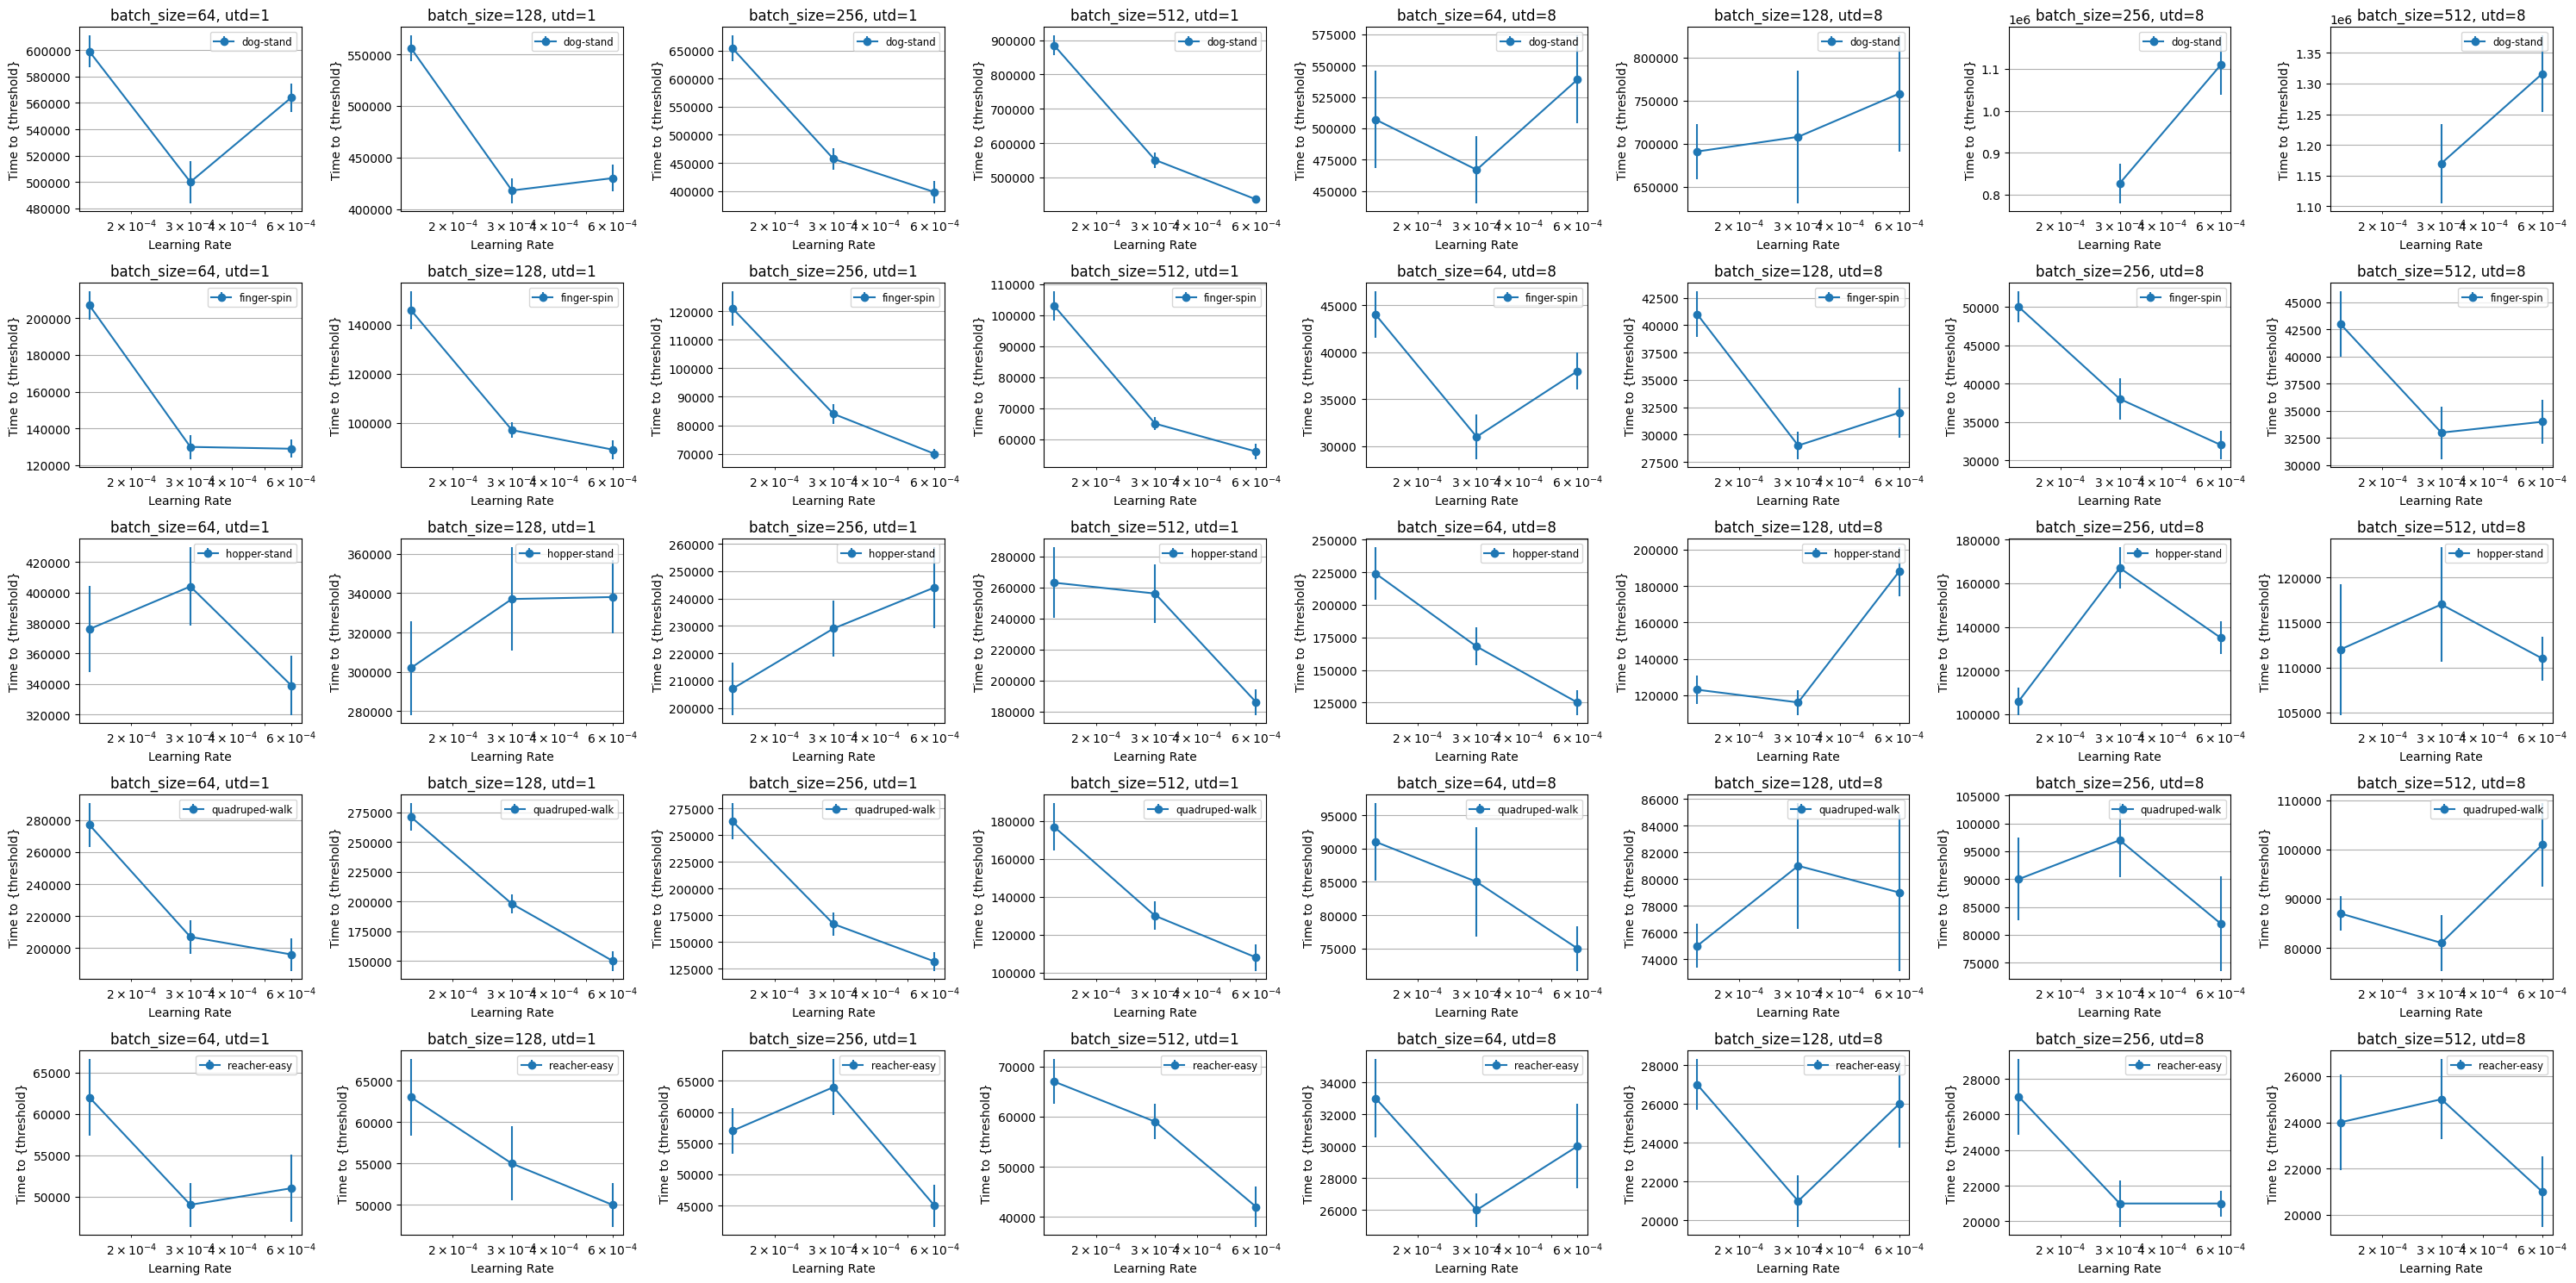

In [73]:
# Plot learning rate vs performance for each environment, batch size and UTD
unique_envs = sorted(df['env_name'].unique())
unique_batch_sizes = sorted(df['batch_size'].unique()) 
unique_utds = sorted(df['utd'].unique())

cols = 8
fig, axs = plt.subplots(5, 8, figsize=(30, 15))

plot_idx = 0
for row, env in enumerate(unique_envs):   
    for utd in unique_utds:
        for batch_size in unique_batch_sizes:
            col = plot_idx % cols
            env_data = df[df['env_name'] == env]
            data = env_data[(env_data['batch_size'] == batch_size) & 
                           (env_data['utd'] == utd)]
            
            if len(data) == 0:
                continue
            
            # Group by learning rate
            lr_groups = data.groupby('learning_rate')
            threshold_i = -1
            threshold = thresholds[threshold_i]
            # smooth = lambda x: x

            time_to_threshold = lr_groups.apply(lambda x: np.mean([r[threshold_i] for r in x['crossings']]))
            sem = lr_groups.apply(lambda x: np.mean([r[threshold_i] for r in x['crossings_sem']]))
            
            lrs = sorted(lr_groups.groups.keys())
            means = [time_to_threshold[lr] for lr in lrs]
            sems = [sem[lr] for lr in lrs]
            
            axs[row, col].errorbar(lrs, means, yerr=sem, fmt='o-', label=env)
            
            axs[row, col].set_xscale('log')
            axs[row, col].set_xlabel('Learning Rate')
            axs[row, col].set_ylabel('Time to {threshold}')
            axs[row, col].set_title(f'batch_size={batch_size}, utd={utd}')
            axs[row, col].legend(fontsize='small')
            axs[row, col].grid(True)
            
            plot_idx += 1

plt.tight_layout()
plt.show()


In [45]:
# make and print a table with best learning rate for each environment, batch size and UTD
# with environment as rows and utd x batch size as columns

# Group data by environment, batch size and UTD
grouped = df.groupby(['env_name', 'batch_size', 'utd'])

# Find best learning rate for each group
results = []
for (env, bs, utd), group in grouped:
    threshold_i = -1
    
    # Calculate mean time to threshold for each learning rate
    lr_groups = group.groupby('learning_rate')
    time_to_threshold = lr_groups.apply(lambda x: np.mean([r[threshold_i] for r in x['crossings']]))
    
    # Find learning rate with minimum time
    best_lr = time_to_threshold.idxmin()
    min_time = time_to_threshold[best_lr]

    # # calculate the uncertainty-corrected best learning rate using existing function
    # lr_groups_sem = {lr: np.mean([r[threshold_i] for r in group['crossings_sem']]) for lr, group in lr_groups}
    # lrs_unique = sorted(lr_groups.groups.keys())
    # time_to_threshold_dict = {lr: np.mean([r[threshold_i] for r in group['crossings']]) for lr, group in lr_groups}
    # probs = calculate_lr_probabilities(time_to_threshold_dict, lr_groups_sem, lrs_unique)
    # best_lr_uncertainty = sum(lr * prob for lr, prob in zip(lrs_unique, probs))    
    
    results.append({
        'env_name': env,
        'batch_size': bs,
        'utd': utd,
        'best_lr': best_lr,
        # 'best_lr_uncertainty': best_lr_uncertainty,
        'time_to_threshold': min_time
    })

# Create DataFrame
results_df = pd.DataFrame(results)

# Pivot table to get environments as rows and utd x batch_size as columns
pivot_df = results_df.pivot_table(
    index='env_name',
    columns=['utd', 'batch_size'],
    values='best_lr',
    aggfunc='first'
)

# Print formatted table with scientific notation
pd.set_option('display.float_format', '{:.1e}'.format)
print("\nBest Learning Rates:")
print(pivot_df.to_string())

# # print the uncertainty-corrected best learning rates
# pivot_df_uncertainty = results_df.pivot_table(
#     index='env_name',
#     columns=['utd', 'batch_size'],
#     values='best_lr_uncertainty',
#     aggfunc='first'
# )
# pd.set_option('display.float_format', '{:.1e}'.format)
# print("\nUncertainty-Corrected Best Learning Rates:")
# print(pivot_df_uncertainty.to_string())

# Also show time to threshold
time_pivot = results_df.pivot_table(
    index='env_name', 
    columns=['utd', 'batch_size'],
    values='time_to_threshold',
    aggfunc='first'
)

print("\nTime to Threshold:")
print(time_pivot.to_string())

# give correlation between batch size and learning rate
print()
print('correlation between batch size and learning rate',  np.corrcoef(results_df['batch_size'], results_df['best_lr'])[0, 1])
print('correlation between batch size and learning rate for utd=1', np.corrcoef(results_df[results_df['utd'] == 1]['batch_size'], results_df[results_df['utd'] == 1]['best_lr'])[0, 1])
print('correlation between batch size and learning rate for utd=8', np.corrcoef(results_df[results_df['utd'] == 8]['batch_size'], results_df[results_df['utd'] == 8]['best_lr'])[0, 1])



Best Learning Rates:
utd                  1                               8                        
batch_size         64      128     256     512     64      128     256     512
env_name                                                                      
dog-stand      3.0e-04 3.0e-04 6.0e-04 6.0e-04 3.0e-04 1.5e-04 3.0e-04 3.0e-04
finger-spin    6.0e-04 6.0e-04 6.0e-04 6.0e-04 3.0e-04 3.0e-04 6.0e-04 3.0e-04
hopper-stand   6.0e-04 1.5e-04 1.5e-04 6.0e-04 6.0e-04 3.0e-04 1.5e-04 6.0e-04
quadruped-walk 6.0e-04 6.0e-04 6.0e-04 6.0e-04 6.0e-04 1.5e-04 6.0e-04 3.0e-04
reacher-easy   3.0e-04 6.0e-04 6.0e-04 6.0e-04 3.0e-04 3.0e-04 3.0e-04 6.0e-04

Time to Threshold:
utd                  1                               8                        
batch_size         64      128     256     512     64      128     256     512
env_name                                                                      
dog-stand      5.0e+05 4.2e+05 4.0e+05 4.4e+05 4.7e+05 6.9e+05 8.3e+05 1.2e+06
finger-spi

In [46]:
def calculate_lr_probabilities(lr_groups, lr_groups_sem, lrs_unique):
    """Calculate probability of each learning rate being the best and estimate optimal learning rate.
    
    Args:
        lr_groups: Dictionary mapping learning rates to lists of performance values
        lrs_unique: Array of unique learning rate values
        
    Returns:
        best_prob: Array of probabilities that each learning rate is the best
        approx_best_lr: Estimated optimal learning rate
    """
    # Calculate probability of each learning rate being the best 
    from scipy.stats import norm
    
    # Remove any groups with NaN values
    lr_groups = {k: v for k, v in lr_groups.items() if not np.isnan(v).any()}
    lr_groups_sem = {k: v for k, v in lr_groups_sem.items() if not np.isnan(v).any()}
    lrs_unique = [lr for lr in lrs_unique if lr in lr_groups]
    
    if len(lr_groups) == 0:
        return np.array([]), np.nan
            
    distributions = [norm(np.mean(vals), sem) for vals, sem in zip(lr_groups.values(), lr_groups_sem.values())]

    # Calculate probability that each learning rate is better than all others
    probabilities = np.ones((len(distributions), len(distributions)))

    for i in range(len(distributions)):
        for j in range(len(distributions)):
            if i != j:            
                # Calculate p(x>y) using formula: p(x>y) = cdf((mx - my) / sqrt(varx + vary))
                z = (distributions[j].mean() - distributions[i].mean()) / np.sqrt(distributions[i].std()**2 + distributions[j].std()**2)
                probabilities[i,j] = norm.cdf(z)

    # Print probability matrix
    print("\nProbability matrix (p(row>column)):")
    print("LRs:", [f"{lr:.1e}" for lr in lrs_unique])
    
    # Calculate probabilities each learning rate is the best
    best_prob = np.prod(probabilities, axis=1) / np.prod(probabilities, axis=1).sum()
    approx_best_lr = (np.array(lrs_unique) * best_prob).sum()
    
    print('probabilities of being the best:', best_prob)
    print('approximate best learning rate:', f'{approx_best_lr:.2e}')
    
    return best_prob, approx_best_lr, _

def calculate_lr_probabilities(lr_groups, lr_groups_sem, lrs_unique, n_samples=1000):
    """
    Calculate probability distribution over learning rates using Monte Carlo sampling.
    
    Args:
        lr_groups: Dictionary mapping learning rates to mean times
        lr_groups_sem: Dictionary mapping learning rates to standard errors
        lrs_unique: Array of unique learning rates
        n_samples: Number of Monte Carlo samples
        
    Returns:
        lr_probs: Probability distribution over learning rates
        mc_mean: Mean of Monte Carlo samples
    """
    best_lr_samples = []

    for _ in range(n_samples):
        # Sample from normal distribution for each group using means and SEMs
        sampled_times = []
        for group_mean, group_sem in zip(lr_groups.values(), lr_groups_sem.values()):
            # Sample from normal distribution
            sample = np.random.normal(group_mean, group_sem)
            sampled_times.append(sample)
        
        # Find best learning rate for this sample
        best_idx = np.argmin(sampled_times)
        best_lr_samples.append(lrs_unique[best_idx])

    # Calculate probability distribution over learning rates
    lr_counts = np.bincount(np.searchsorted(lrs_unique, best_lr_samples), minlength=len(lrs_unique))
    lr_probs = lr_counts / n_samples

    # Calculate mean and standard error of the Monte Carlo samples
    mc_mean = np.mean(best_lr_samples)
    mc_sem = np.sqrt(np.sum(lr_probs * (lrs_unique - mc_mean)**2))
    
    return lr_probs, mc_mean, mc_sem



# Get uncertainty-corrected best learning rate for each batch size
grouped = df.groupby(['env_name', 'batch_size', 'utd'])

# Find uncertainty-corrected best learning rate for each group
results = []
for (env, bs, utd), group in grouped:
    threshold_i = -1
    
    # Get performance data for each learning rate
    lr_groups = {}
    lr_groups_sem = {}
    lrs_unique = sorted(group['learning_rate'].unique())
    
    for lr in lrs_unique:
        lr_data = group[group['learning_rate'] == lr]
        times = [r[threshold_i] for r in lr_data['crossings']]
        sems = [r[threshold_i] for r in lr_data['crossings_sem']]
        lr_groups[lr] = times
        lr_groups_sem[lr] = sems
        
    # Calculate uncertainty-corrected best learning rate
    best_prob, best_lr, best_sem = calculate_lr_probabilities(lr_groups, lr_groups_sem, lrs_unique)
    
    # Get mean time to threshold for best learning rate
    best_times = lr_groups[lrs_unique[np.argmax(best_prob)]]
    min_time = np.mean(best_times)
    
    results.append({
        'env_name': env,
        'batch_size': bs,
        'utd': utd,
        'best_lr_uncertainty': best_lr,
        'best_lr_sem': best_sem,
        'time_to_threshold': min_time
    })

# Create DataFrame
results_df_uncertainty = pd.DataFrame(results)

# Pivot table to get environments as rows and utd x batch_size as columns  
pivot_df_uncertainty = results_df_uncertainty.pivot_table(
    index='env_name',
    columns=['utd', 'batch_size'],
    values='best_lr_uncertainty',
    aggfunc='first'
)

# Print formatted table with scientific notation
pd.set_option('display.float_format', '{:.1e}'.format)
print("\nBest Learning Rates:")
print(pivot_df_uncertainty.to_string())

# also print the old best learning rates
# Create pivot table for original results
pivot_df = results_df.pivot_table(
    index='env_name',
    columns=['utd', 'batch_size'],
    values='best_lr',
    aggfunc='first'
)

print("\nOriginal Best Learning Rates (without uncertainty correction):")
print(pivot_df.to_string())



Best Learning Rates:
utd                  1                               8                        
batch_size         64      128     256     512     64      128     256     512
env_name                                                                      
dog-stand      3.0e-04 3.8e-04 5.9e-04 6.0e-04 2.9e-04 2.7e-04 1.5e-04 1.5e-04
finger-spin    4.7e-04 5.9e-04 6.0e-04 6.0e-04 3.0e-04 3.4e-04 5.9e-04 4.2e-04
hopper-stand   5.3e-04 2.1e-04 1.6e-04 6.0e-04 6.0e-04 2.6e-04 1.5e-04 3.8e-04
quadruped-walk 5.3e-04 6.0e-04 6.0e-04 5.9e-04 5.5e-04 2.7e-04 4.9e-04 2.8e-04
reacher-easy   4.0e-04 5.4e-04 6.0e-04 6.0e-04 3.2e-04 3.1e-04 4.5e-04 5.5e-04

Original Best Learning Rates (without uncertainty correction):
utd                  1                               8                        
batch_size         64      128     256     512     64      128     256     512
env_name                                                                      
dog-stand      3.0e-04 3.0e-04 6.0e-04 6.0e-0

best learning rate: 2.6e-04 ± 1.5e-04 = [1.2e-04, 4.1e-04]
[0.00015, 0.0003, 0.0006] [0.507 0.365 0.128]


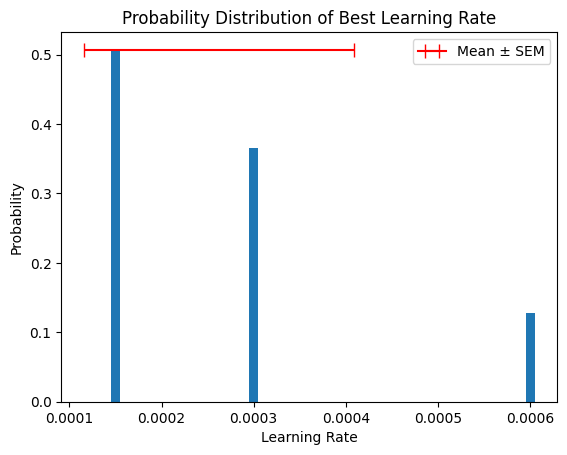

In [51]:
# get lr for finger-spin, utd 1, batch size 64
# Get data for finger-spin with UTD=1 and batch_size=64
group = df[
    (df['env_name'] == 'dog-stand') & 
    (df['utd'] == 8) & 
    (df['batch_size'] == 128)
]

lr_groups = {}
lr_groups_sem = {}
lrs_unique = sorted(group['learning_rate'].unique())
n_samples = 1000
threshold_i = -1

for lr in lrs_unique:
    lr_data = group[group['learning_rate'] == lr]
    times = [r[threshold_i] for r in lr_data['crossings']]
    sems = [r[threshold_i] for r in lr_data['crossings_sem']]
    lr_groups[lr] = times
    lr_groups_sem[lr] = sems


best_lr_samples = []

for _ in range(n_samples):
    # Sample from normal distribution for each group using means and SEMs
    sampled_times = []
    for group_mean, group_sem in zip(lr_groups.values(), lr_groups_sem.values()):
        # Sample from normal distribution
        sample = np.random.normal(group_mean, group_sem)
        sampled_times.append(sample)
    
    # Find best learning rate for this sample
    best_idx = np.argmin(sampled_times)
    best_lr_samples.append(lrs_unique[best_idx])

# Calculate probability distribution over learning rates
lr_counts = np.bincount(np.searchsorted(lrs_unique, best_lr_samples), minlength=len(lrs_unique))
lr_probs = lr_counts / n_samples

# Calculate mean and standard error of the Monte Carlo samples
mc_mean = np.mean(best_lr_samples)
mc_sem = np.sqrt(np.sum(lr_probs * (lrs_unique - mc_mean)**2))

print(f'best learning rate: {mc_mean:.1e} ± {mc_sem:.1e} = [{mc_mean - mc_sem:.1e}, {mc_mean + mc_sem:.1e}]')
print(lrs_unique, lr_probs)

# plot the probability distribution
plt.bar(lrs_unique, lr_probs, width=1e-5)
# Plot error bars for standard error
plt.errorbar(mc_mean, np.max(lr_probs), xerr=mc_sem, color='red', capsize=5, label='Mean ± SEM')
plt.legend()

# plt.xscale('log')
plt.ylabel('Probability')
plt.xlabel('Learning Rate')
plt.title('Probability Distribution of Best Learning Rate')
plt.show()


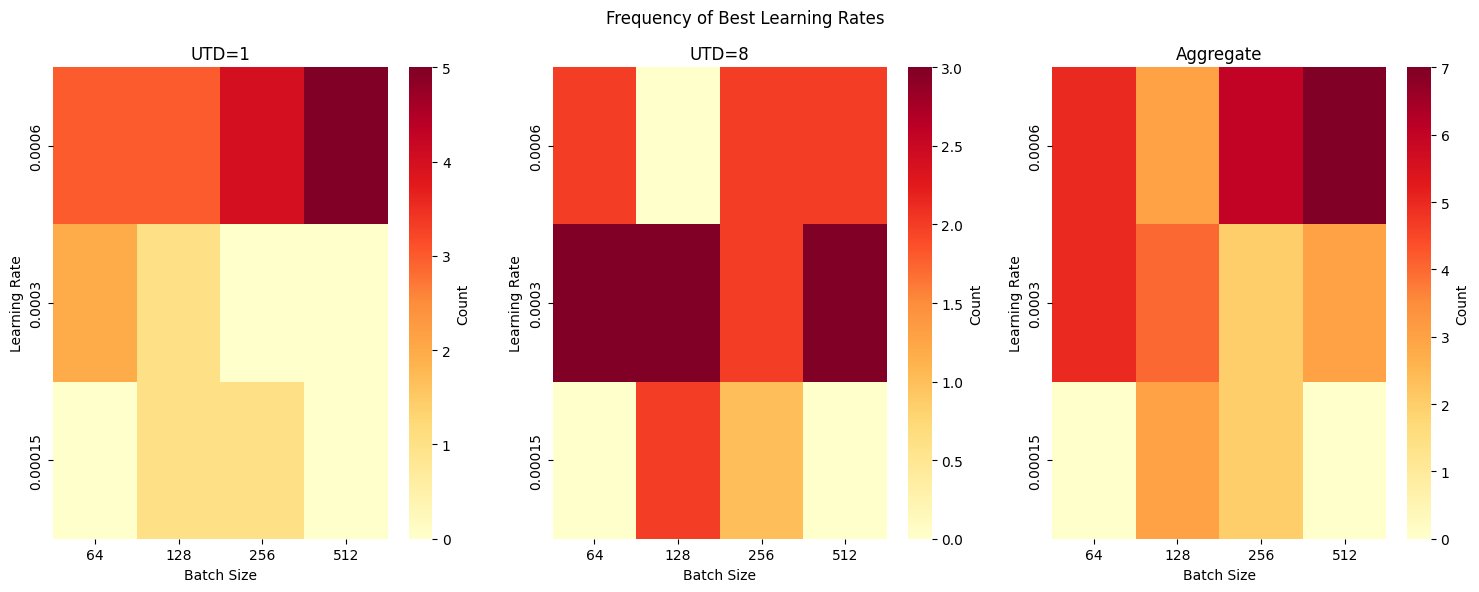

In [52]:
# plot a heatmap of learning rate vs batch size. that is, for each learning rate and batch size, plot the number of times it was the best learning rate

# Create pivot table for heatmap
heatmap_data = results_df.pivot_table(
    index='best_lr',
    columns='batch_size',
    values='env_name',
    aggfunc='count',
    fill_value=0
)

# Create figure with three subplots - one for each UTD value plus aggregate
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 6))
fig.suptitle('Frequency of Best Learning Rates')

# Plot heatmap for UTD=1
utd1_data = results_df[results_df['utd'] == 1].pivot_table(
    index='best_lr',
    columns='batch_size',
    values='env_name', 
    aggfunc='count',
    fill_value=0
)
sns.heatmap(utd1_data, ax=ax1, cmap='YlOrRd', cbar_kws={'label': 'Count'})
ax1.invert_yaxis()  # Flip y-axis
ax1.set_title('UTD=1')
ax1.set_ylabel('Learning Rate')
ax1.set_xlabel('Batch Size')

# Plot heatmap for UTD=8  
utd8_data = results_df[results_df['utd'] == 8].pivot_table(
    index='best_lr',
    columns='batch_size',
    values='env_name',
    aggfunc='count', 
    fill_value=0
)
sns.heatmap(utd8_data, ax=ax2, cmap='YlOrRd', cbar_kws={'label': 'Count'})
ax2.invert_yaxis()  # Flip y-axis
ax2.set_title('UTD=8')
ax2.set_ylabel('Learning Rate')
ax2.set_xlabel('Batch Size')

# Plot aggregate heatmap across all UTD values
aggregate_data = results_df.pivot_table(
    index='best_lr',
    columns='batch_size',
    values='env_name',
    aggfunc='count',
    fill_value=0
)
sns.heatmap(aggregate_data, ax=ax3, cmap='YlOrRd', cbar_kws={'label': 'Count'})
ax3.invert_yaxis()  # Flip y-axis
ax3.set_title('Aggregate')
ax3.set_ylabel('Learning Rate')
ax3.set_xlabel('Batch Size')

plt.tight_layout()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Overall correlation between best learning rate and batch size: 0.23308576589379779


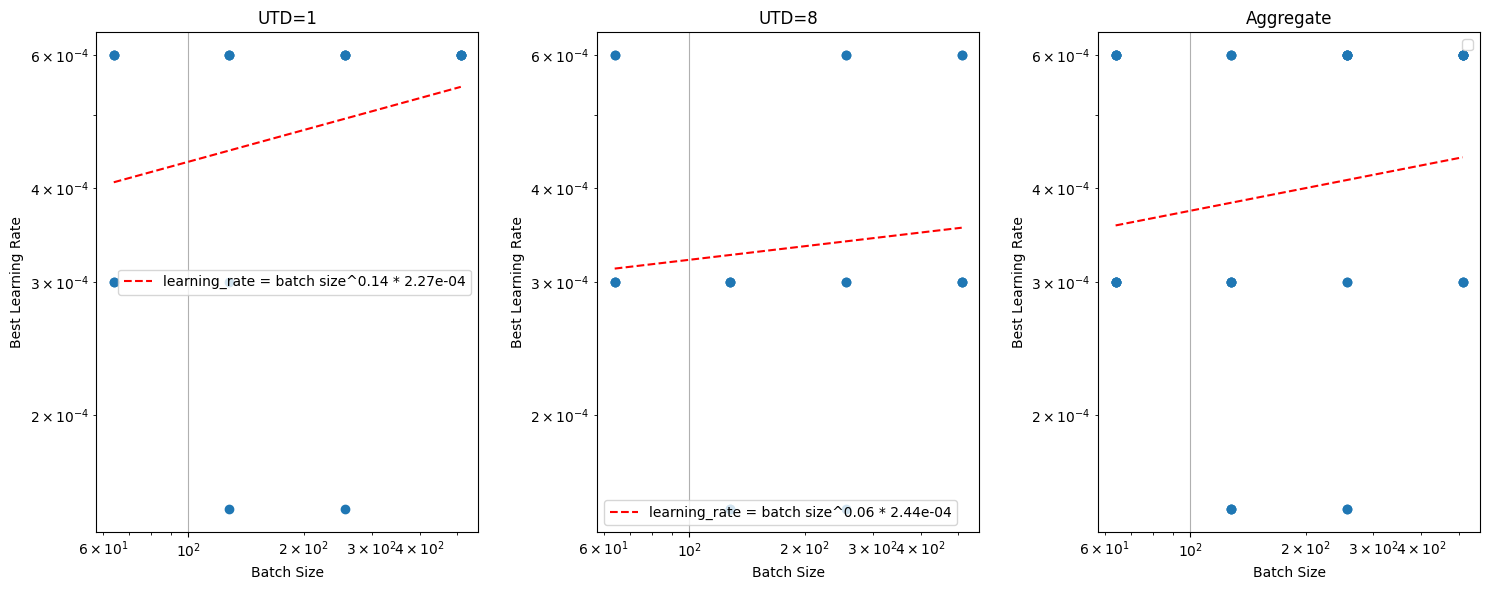

In [174]:
# now visualize the correlation between batch size and learning rate
# Calculate correlation between batch size and best learning rate
correlation = results_df['best_lr'].corr(results_df['batch_size'])
print(f"Overall correlation between best learning rate and batch size: {correlation}")

# Create scatter plot
plt.figure(figsize=(15, 6))

# Plot for UTD=1
plt.subplot(131)
utd1_data = results_df[results_df['utd'] == 1]
plt.scatter(utd1_data['batch_size'], utd1_data['best_lr'])
# Add correlation line
z1 = np.polyfit(np.log10(utd1_data['batch_size']), np.log10(utd1_data['best_lr']), 1)
p1 = np.poly1d(z1)
x1 = np.logspace(np.log10(utd1_data['batch_size'].min()), np.log10(utd1_data['batch_size'].max()), 100)
plt.plot(x1, 10**p1(np.log10(x1)), 'r--', label=f'learning_rate = batch size^{z1[0]:.2f} * {10**z1[1]:.2e}')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Best Learning Rate')
plt.xlabel('Batch Size')
plt.title('UTD=1')
plt.grid(True)
plt.legend()

# Plot for UTD=8
plt.subplot(132)
utd8_data = results_df[results_df['utd'] == 8]
plt.scatter(utd8_data['batch_size'], utd8_data['best_lr'])
# Add correlation line
z8 = np.polyfit(np.log10(utd8_data['batch_size']), np.log10(utd8_data['best_lr']), 1)
p8 = np.poly1d(z8)
x8 = np.logspace(np.log10(utd8_data['batch_size'].min()), np.log10(utd8_data['batch_size'].max()), 100)
plt.plot(x8, 10**p8(np.log10(x8)), 'r--', label=f'learning_rate = batch size^{z8[0]:.2f} * {10**z8[1]:.2e}')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Best Learning Rate')
plt.xlabel('Batch Size')
plt.title('UTD=8')
plt.grid(True)
plt.legend()

# Plot aggregate
plt.subplot(133)
plt.scatter(results_df['batch_size'], results_df['best_lr'])
# Add correlation line
z = np.polyfit(np.log10(results_df['batch_size']), np.log10(results_df['best_lr']), 1)
p = np.poly1d(z)
x = np.logspace(np.log10(results_df['batch_size'].min()), np.log10(results_df['batch_size'].max()), 100)
plt.plot(x, 10**p(np.log10(x)), 'r--', label=f'learning_rate = batch size^{z[0]:.2f} * {10**z[1]:.2e}')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Best Learning Rate')
plt.xlabel('Batch Size')
plt.title('Aggregate')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


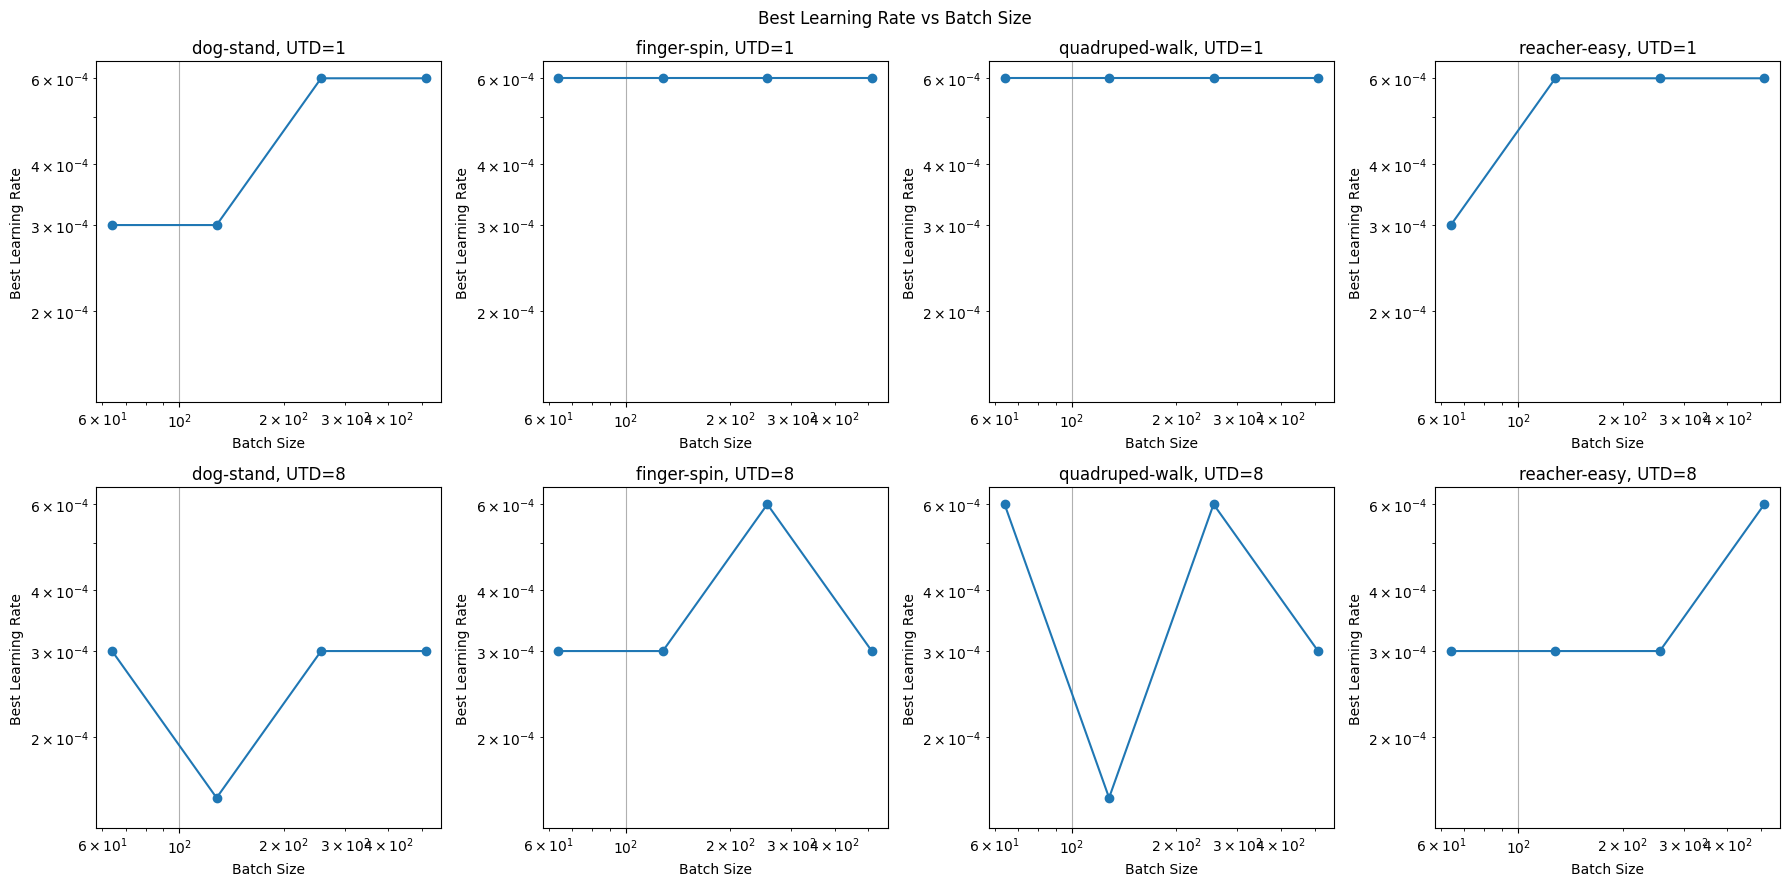

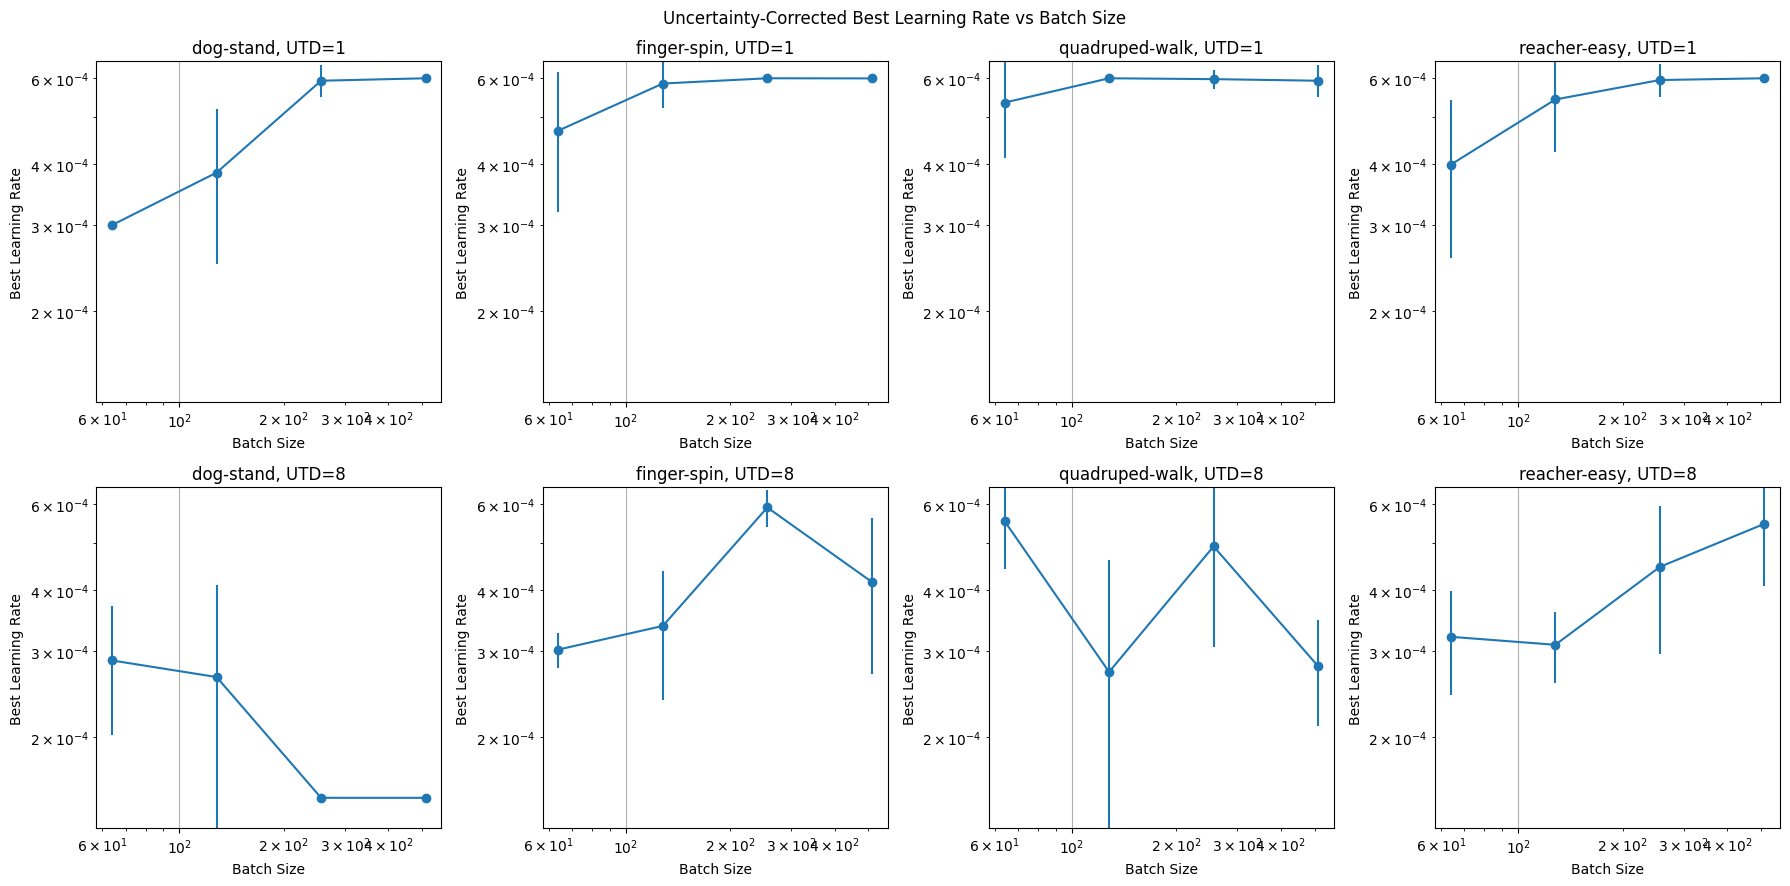

In [50]:
# for each utd and env, plot best learning rate depending on batch size
# Plot best learning rate vs batch size for each UTD and environment
unique_envs = sorted([env for env in df['env_name'].unique() if env != 'hopper-stand'])
unique_utds = sorted(df['utd'].unique())

fig, axs = plt.subplots(len(unique_utds), len(unique_envs), figsize=(18, 9))
fig.suptitle('Best Learning Rate vs Batch Size')

for i, env in enumerate(unique_envs):
    for j, utd in enumerate(unique_utds):
        env_data = results_df[
            (results_df['env_name'] == env) & 
            (results_df['utd'] == utd)
        ]
        
        if len(env_data) > 0:
            batch_sizes = env_data['batch_size']
            best_lrs = env_data['best_lr']
            
            axs[j, i].plot(batch_sizes, best_lrs, 'o-')
            axs[j, i].set_xscale('log')
            axs[j, i].set_yscale('log')
            axs[j, i].set_ylim(1.3e-4, 6.5e-4)
            axs[j, i].set_xlabel('Batch Size')
            axs[j, i].set_ylabel('Best Learning Rate')
            axs[j, i].set_title(f'{env}, UTD={utd}')
            axs[j, i].grid(True)

plt.tight_layout()
plt.show()

# print this but for uncertainty-corrected best learning rates
# Plot best learning rate vs batch size for each UTD and environment using uncertainty-corrected values
unique_envs = sorted([env for env in df['env_name'].unique() if env != 'hopper-stand'])
unique_utds = sorted(df['utd'].unique())

fig, axs = plt.subplots(len(unique_utds), len(unique_envs), figsize=(18, 9))
fig.suptitle('Uncertainty-Corrected Best Learning Rate vs Batch Size')

for i, env in enumerate(unique_envs):
    for j, utd in enumerate(unique_utds):
        env_data = results_df_uncertainty[
            (results_df_uncertainty['env_name'] == env) & 
            (results_df_uncertainty['utd'] == utd)
        ]
        
        if len(env_data) > 0:
            batch_sizes = env_data['batch_size']
            best_lrs = env_data['best_lr_uncertainty'] 
            best_lrs_err = env_data['best_lr_sem']
            axs[j, i].errorbar(batch_sizes, best_lrs, yerr=best_lrs_err, fmt='o-')
            axs[j, i].set_xscale('log')
            axs[j, i].set_yscale('log')
            axs[j, i].set_ylim(1.3e-4, 6.5e-4)
            axs[j, i].set_xlabel('Batch Size')
            axs[j, i].set_ylabel('Best Learning Rate')
            axs[j, i].set_title(f'{env}, UTD={utd}')
            axs[j, i].grid(True)

plt.tight_layout()  
plt.show()


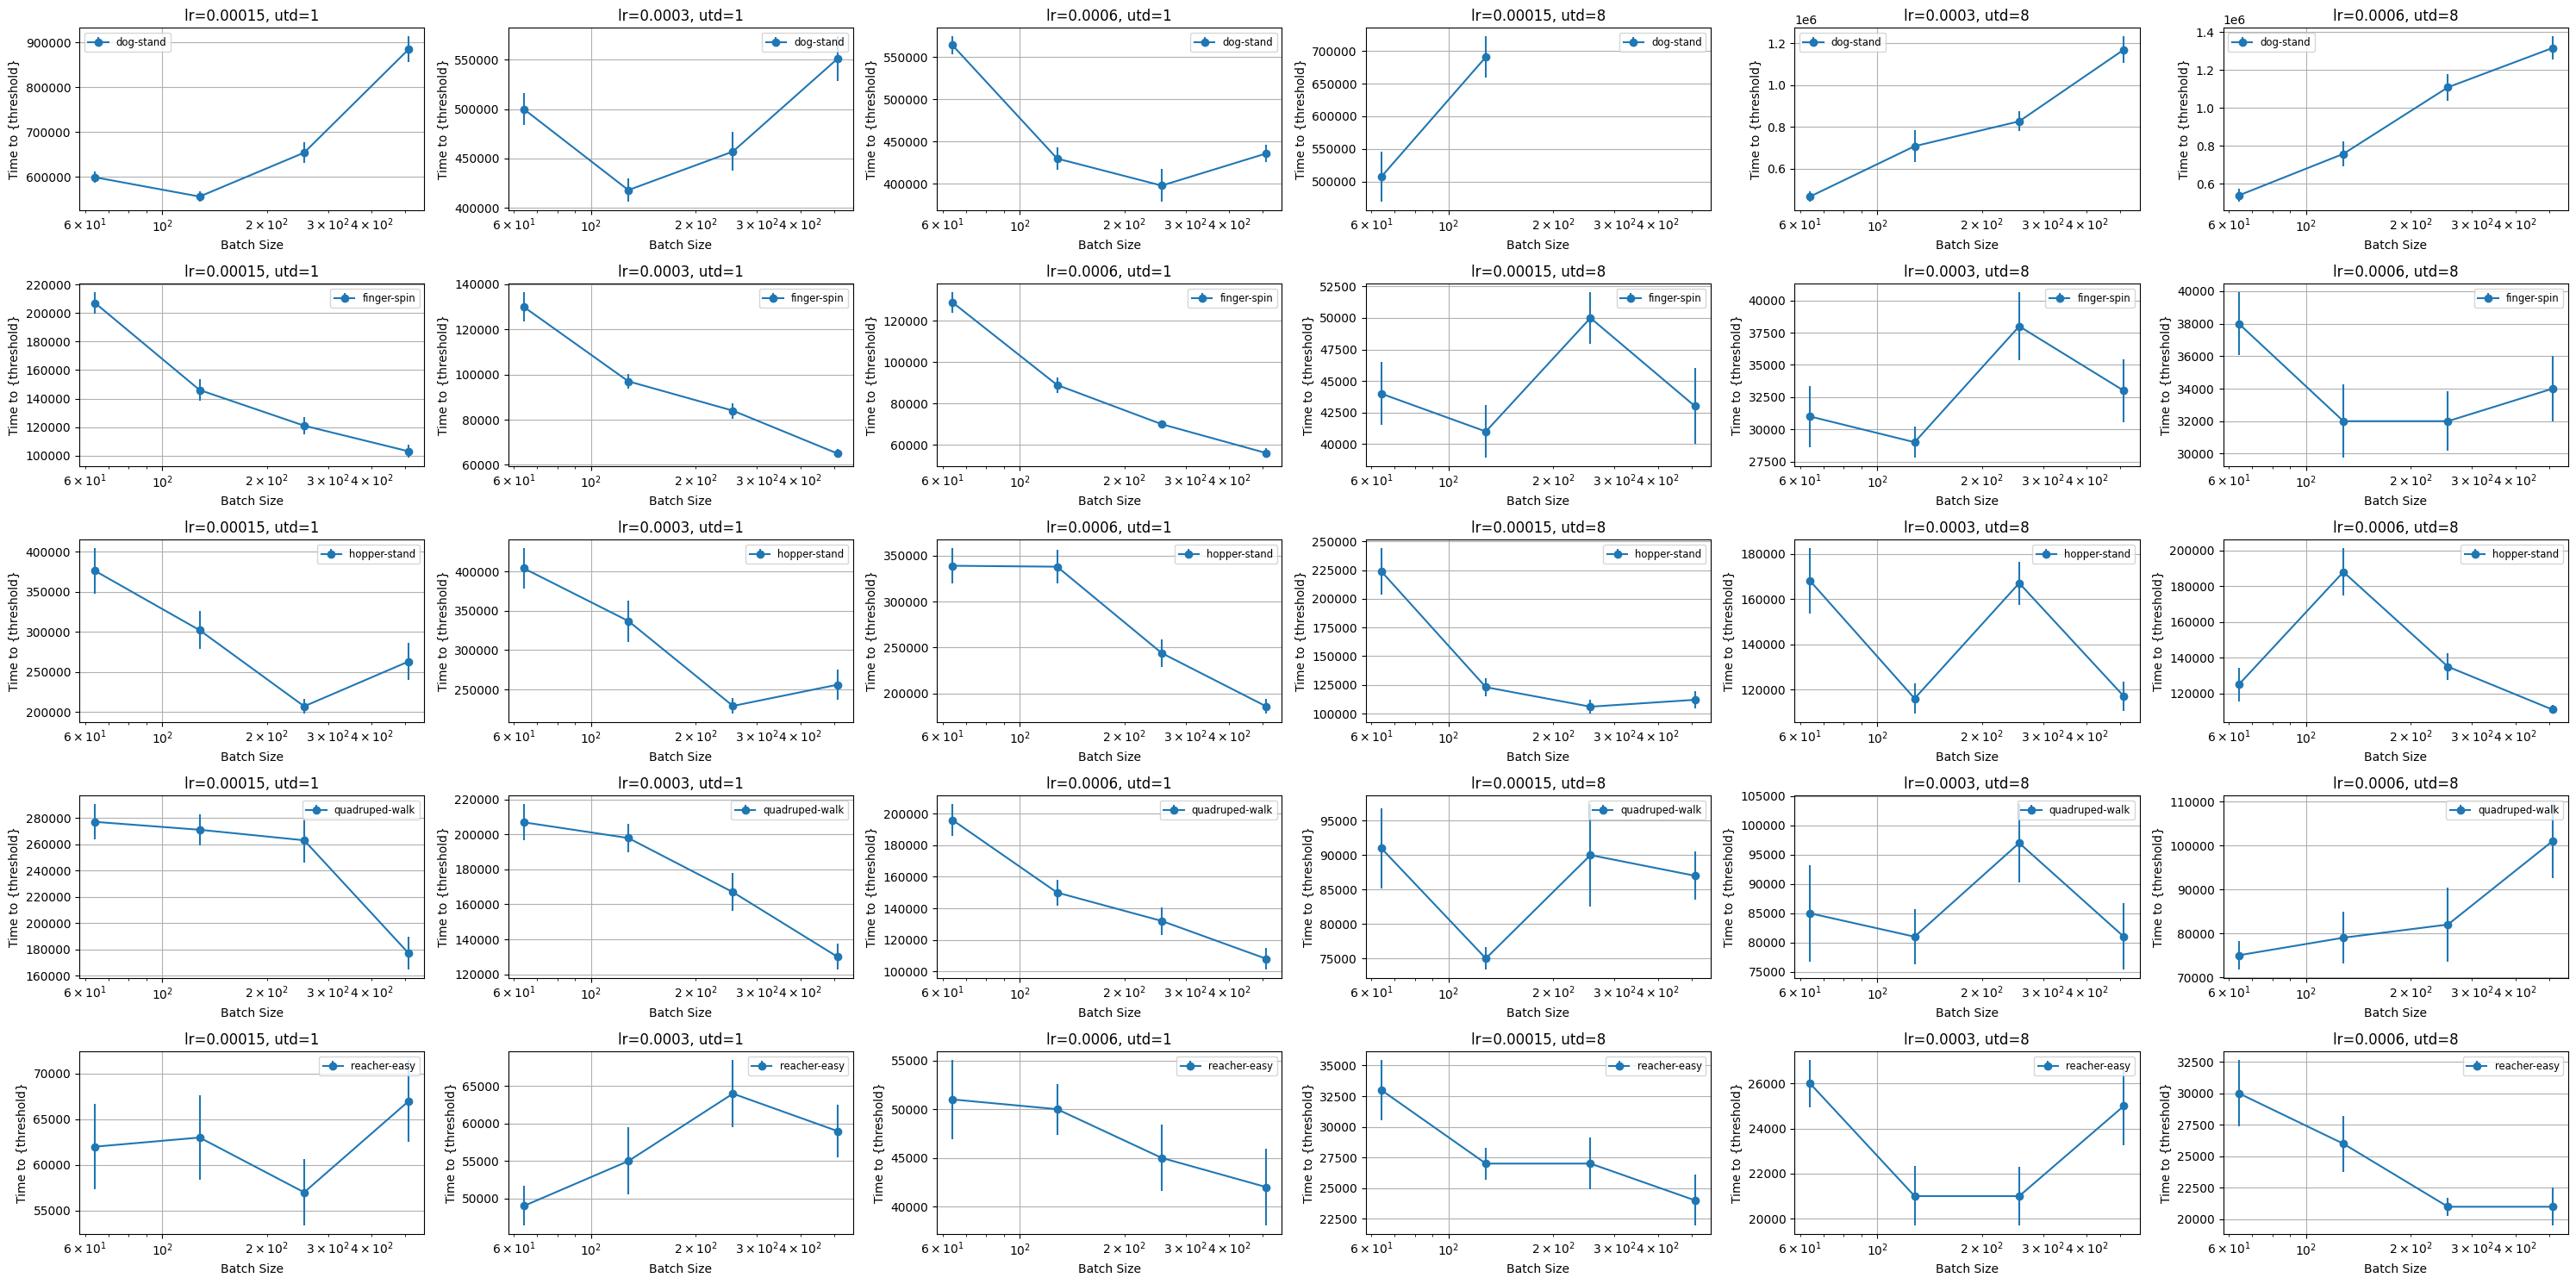

In [95]:
# Plot batch size vs performance for each environment, learning rate and UTD
unique_envs = sorted(df['env_name'].unique())
unique_lrs = sorted(df['learning_rate'].unique())
unique_utds = sorted(df['utd'].unique())

cols = 6
fig, axs = plt.subplots(5, cols, figsize=(30, 15))

plot_idx = 0
for row, env in enumerate(unique_envs):   
    for utd in unique_utds:
        for lr in unique_lrs:
            col = plot_idx % cols
            env_data = df[df['env_name'] == env]
            data = env_data[(env_data['learning_rate'] == lr) & 
                           (env_data['utd'] == utd)]
            
            if len(data) == 0:
                continue
            
            # Group by batch size
            batch_groups = data.groupby('batch_size')
            threshold_i = -1
            threshold = thresholds[threshold_i]

            time_to_threshold = batch_groups.apply(lambda x: np.mean([r[threshold_i] for r in x['crossings']]))
            sem = batch_groups.apply(lambda x: np.mean([r[threshold_i] for r in x['crossings_sem']]))
            
            batch_sizes = sorted(batch_groups.groups.keys())
            means = [time_to_threshold[bs] for bs in batch_sizes]
            sems = [sem[bs] for bs in batch_sizes]
            axs[row, col].errorbar(batch_sizes, means, yerr=sems, fmt='o-', label=env)
            
            axs[row, col].set_xscale('log')
            axs[row, col].set_xlabel('Batch Size')
            axs[row, col].set_ylabel('Time to {threshold}')
            axs[row, col].set_title(f'lr={lr}, utd={utd}')
            axs[row, col].legend(fontsize='small')
            axs[row, col].grid(True)
            
            plot_idx += 1

plt.tight_layout()
plt.show()


dog-stand 8 [0.0003, 0.00015, 0.00015, 0.00015] [467000.0, 691000.0, nan, nan] 0


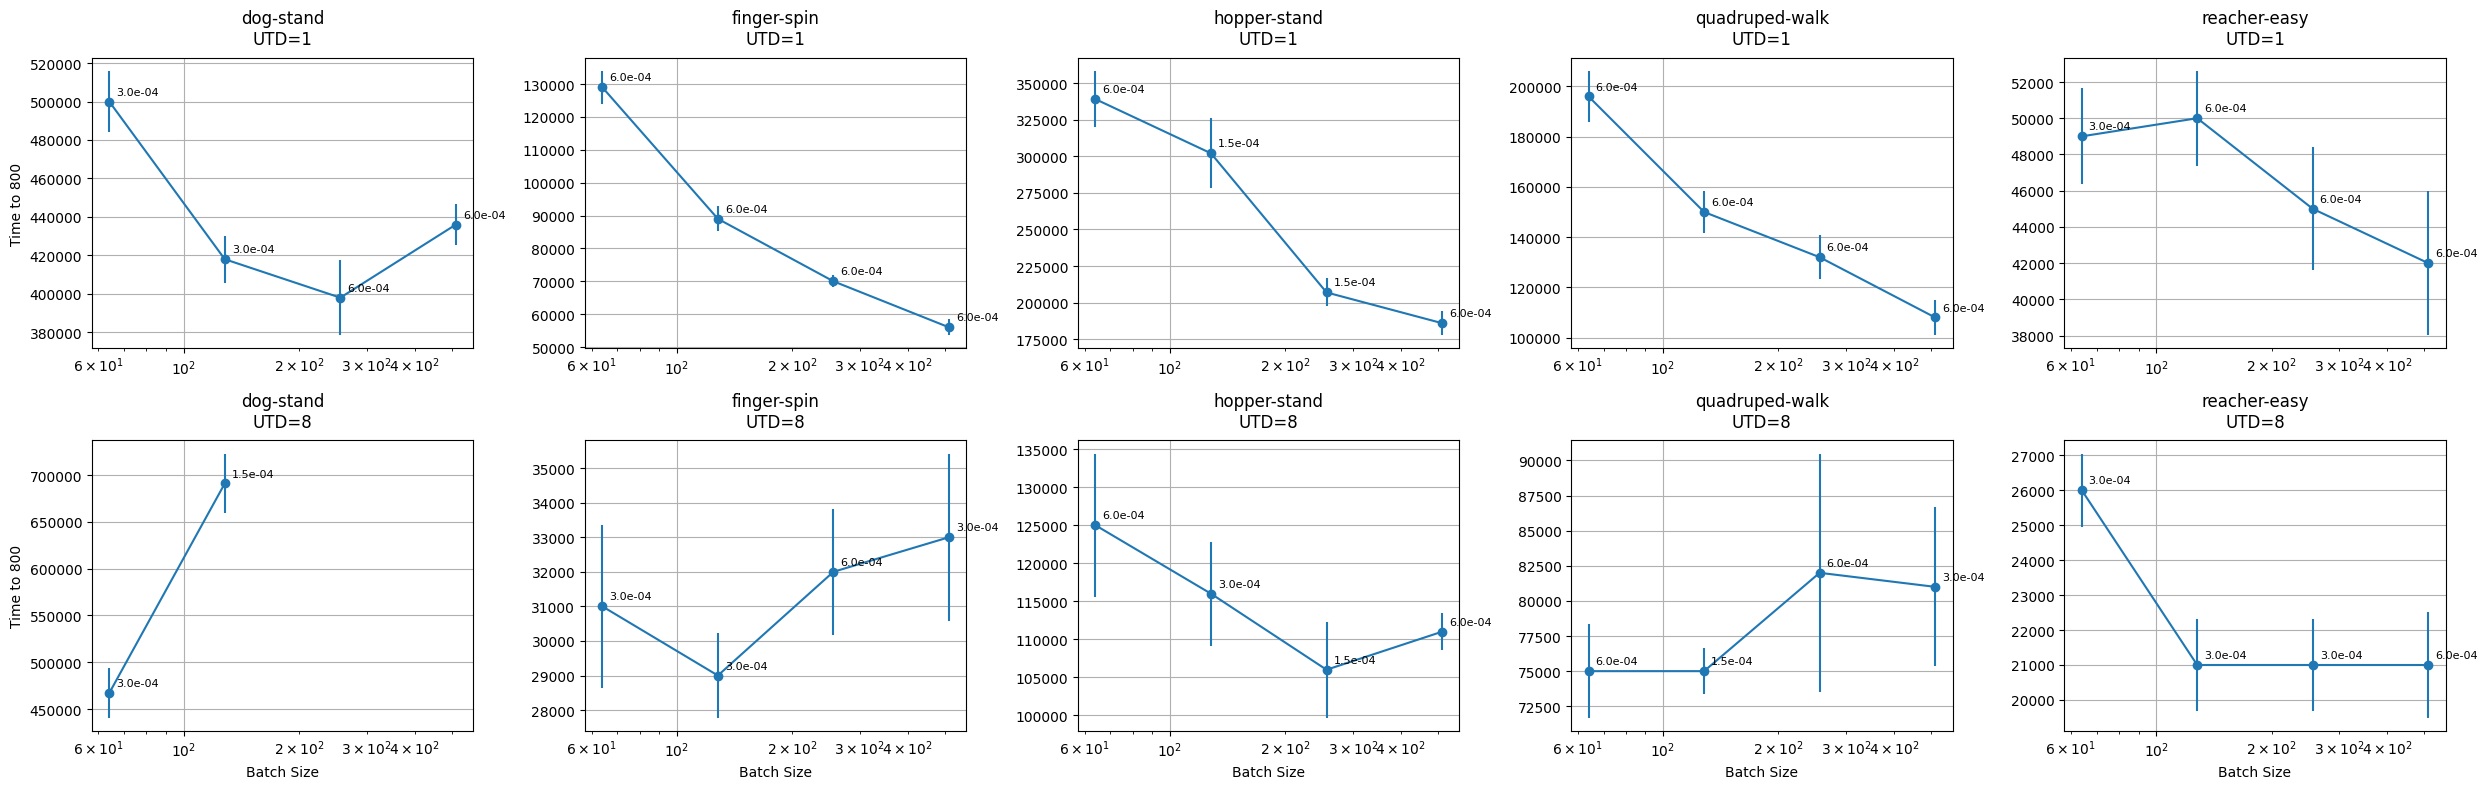

In [89]:
# Plot time to threshold vs batch size using optimal learning rates
unique_envs = sorted(df['env_name'].unique())
unique_utds = sorted(df['utd'].unique())

rows = len(unique_utds)
cols = len(unique_envs)
fig, axs = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))

for row, utd in enumerate(unique_utds):
    for col, env in enumerate(unique_envs):
        env_data = df[(df['env_name'] == env) & (df['utd'] == utd)]
        
        # For each batch size, get data for optimal learning rate
        batch_sizes = sorted(env_data['batch_size'].unique())
        means = []
        sems = []
        optimal_lrs = []
        
        for bs in batch_sizes:
            batch_data = env_data[env_data['batch_size'] == bs]
            
            # Get data for optimal learning rate
            threshold_i = -1
            threshold = thresholds[threshold_i]
            
            times = [r[threshold_i] for r in batch_data['crossings']]
            errors = [r[threshold_i] for r in batch_data['crossings_sem']]
            lrs = batch_data['learning_rate'].values
            
            # Find minimum mean time across learning rates
            min_idx = np.argmin([np.mean(t) for t in times])
            means.append(np.mean(times[min_idx]))
            sems.append(np.mean(errors[min_idx]))
            optimal_lrs.append(lrs[min_idx])

        if env == 'dog-stand' and utd == 8:
            print(env, utd, optimal_lrs, means, min_idx)
        line = axs[row,col].errorbar(batch_sizes, means, yerr=sems, fmt='o-')
        axs[row,col].set_xscale('log')
        
        # Add learning rate annotations
        for i, (bs, lr) in enumerate(zip(batch_sizes, optimal_lrs)):
            axs[row,col].annotate(f'{lr:.1e}', 
                                (bs, means[i]),
                                xytext=(5, 5), 
                                textcoords='offset points',
                                fontsize=8)
        
        # Only add x-label for bottom row
        if row == rows-1:
            axs[row,col].set_xlabel('Batch Size')
        
        # Only add y-label for leftmost column    
        if col == 0:
            axs[row,col].set_ylabel(f'Time to {threshold}')
            
        # Add environment name as title for top row, UTD for all rows
        if row == 0:
            axs[row,col].set_title(f'{env}')
        axs[row,col].set_title(f'{env}\nUTD={utd}', pad=10)
        axs[row,col].grid(True)

plt.tight_layout()
plt.show()


In [10]:
batch_utd_data

NameError: name 'batch_utd_data' is not defined

  0%|          | 0/125 [00:00<?, ?it/s]/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in power
  # Remove the CWD from sys.path while we load stuff.
100%|██████████| 125/125 [00:01<00:00, 90.01it/s]


loss 0.007633970780512636
y = 8.77e+00 / (1 + x/2.57e-03)^-2.62e-01


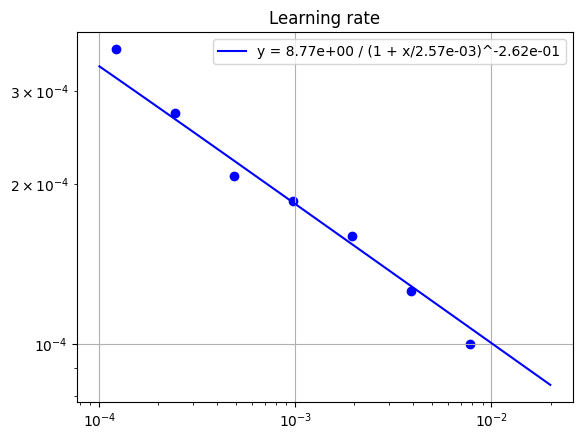

In [146]:
# large-batch training - fit() - uncertainty-corrected

def lr_rule_min(args, *params):
    x,y = params
    a,b,c = args
    return ((lr_rule(x,a,b,c) - y) ** 2).mean()
    # return ((np.log(lr_rule(x,a,b,c) / y)) ** 2).mean()

def lr_rule(x, a, b, c):
    return c * (1 + x/b) ** (-a)

n_parallel = np.array([128, 1024, 2048, 4096, 8192, 16384, 32768, 65536])
utd = 1/n_parallel * 8
learning_rate = np.array([4e-5, 1e-4, 1.26e-4, 1.6e-4, 2e-4, 2e-4, 2.5e-4, 3.7e-4])
learning_rate = np.array([4e-5, 1e-4, 1.26e-4, 1.6e-4, 1.86e-4, 2.07e-4, 2.73e-4, 3.6e-4]) # uncertainty corrected
fit_data_points = [3, 4, 5, 6]
plot_data_points = [1, 2, 3, 4, 5, 6, 7]
tried_values = [[4e-5], [1e-4, 2e-4], [1.26e-4, 1e-4, 2e-4], [1.6e-4, 1e-4, 2e-4], [2e-4, 1e-4], [2e-4, 2.5e-4, 3.2e-4], [2.5e-4, 2e-4], [3.2e-4, 2.7e-4, 3.7e-4]]

scaling = [1000, 10000]
fitted_params = fit(utd[fit_data_points] * scaling[0], learning_rate[fit_data_points] * scaling[1], lr_rule_min,
                     [slice(-4, 4, 1.6),slice(1e-5, 5e-4, 1e-4),slice(-10, 10, 4)], maxiter=100)
print('loss', lr_rule_min(fitted_params, utd[fit_data_points] * scaling[0], learning_rate[fit_data_points] * scaling[1]))
a, b, c = fitted_params
x_smooth = np.logspace(-1, 1.3, 100)
y_fitted = lr_rule(x_smooth, a, b, c)

# for i, lr_tried in enumerate(tried_values):
#     if i in plot_data_points:
#         plt.scatter([utd[i]]*len(lr_tried), lr_tried, color='lightblue')    
plt.title('Learning rate')
plt.scatter(utd[plot_data_points], learning_rate[plot_data_points], color='blue')
plt.plot(x_smooth / scaling[0], y_fitted / scaling[1], 'b-', label=f'y = {c:.2e} / (1 + x/{b:.2e})^-{a:.2e}')
print(f'y = {c:.2e} / (1 + x/{b:.2e})^-{a:.2e}')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()

In [25]:
# Extrapolate

def get_lr(n_parallel):
    utd = 8/n_parallel * scaling[0]  # Scale UTD ratio same as training data
    predicted_lr = lr_rule(utd, a, b, c) / scaling[1]  # Unscale the prediction
    return predicted_lr

print(f'Predicted learning rate for n_parallel=131072: {get_lr(131072):.2e}')
print(f'Predicted learning rate for n_parallel=65536: {get_lr(65536):.2e}')
print(f'Predicted learning rate for n_parallel=32768: {get_lr(32768):.2e}')


Predicted learning rate for n_parallel=131072: 3.78e-04
Predicted learning rate for n_parallel=65536: 3.18e-04
Predicted learning rate for n_parallel=32768: 2.67e-04


  0%|          | 0/125 [00:00<?, ?it/s]/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in power
  # Remove the CWD from sys.path while we load stuff.
100%|██████████| 125/125 [00:01<00:00, 104.89it/s]


loss 0.0025927195200633993



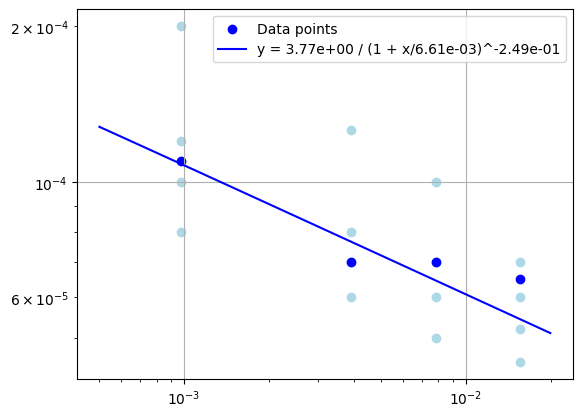

In [8]:
# Pushing, 2x width - fit


n_parallel = np.array([512, 1024, 2048, 8192])
utd = 1/n_parallel * 8
learning_rate = np.array([6e-5, 7e-5, 7e-5, 1e-4])
learning_rate = np.array([6.5e-5, 7e-5, 7e-5, 1.1e-4]) # uncertainty corrected
fit_data_points = [1, 2, 3]
plot_data_points = [0, 1, 2, 3]
lr_tried_values = [[6e-5, 7e-5], [5e-5, 1e-4], [6e-5, 1.26e-4], [1e-4, 2e-4]]
lr_tried_values = [[5.2e-5, 4.5e-5, 6e-5, 7e-5], [5e-5, 6e-5, 7e-5, 1e-4], [6e-5, 7e-5, 8e-5, 1.26e-4], [1.2e-4, 8e-5, 1e-4, 2e-4]] # values to try

scaling = [1000, 10000]
fitted_params = fit(utd[fit_data_points] * scaling[0], learning_rate[fit_data_points] * scaling[1], lr_rule_min,
                     [slice(-4, 4, 1.6),slice(1e-5, 5e-4, 1e-4),slice(-10, 10, 4)], maxiter=100)
print('loss', lr_rule_min(fitted_params, utd[fit_data_points] * scaling[0], learning_rate[fit_data_points] * scaling[1]))
a, b, c = fitted_params
x_smooth = np.logspace(-0.3, 1.3, 100)
y_fitted = lr_rule(x_smooth, a, b, c)

for i, lr_tried in enumerate(lr_tried_values):
    plt.scatter([utd[i]]*len(lr_tried), lr_tried, color='lightblue')
plt.scatter(utd[plot_data_points], learning_rate[plot_data_points], color='blue', label='Data points')
plt.plot(x_smooth / scaling[0], y_fitted / scaling[1], 'b-', label=f'y = {c:.2e} / (1 + x/{b:.2e})^-{a:.2e}')
print()
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()

In [70]:
# Extrapolate

def get_lr(n_parallel):
    utd = 8/n_parallel * scaling[0]  # Scale UTD ratio same as training data
    predicted_lr = lr_rule(utd, a, b, c) / scaling[1]  # Unscale the prediction
    return predicted_lr

print(f'Predicted learning rate for n_parallel=256: {get_lr(256):.2e}')
print(f'Predicted learning rate for n_parallel=512: {get_lr(512):.2e}')
print(f'Predicted learning rate for n_parallel=1024: {get_lr(1024):.2e}')
print(f'Predicted learning rate for n_parallel=2048: {get_lr(2048):.2e}')
print(f'Predicted learning rate for n_parallel=4096: {get_lr(4096):.2e}')
print(f'Predicted learning rate for n_parallel=8192: {get_lr(8192):.2e}')


Predicted learning rate for n_parallel=256: 4.49e-05
Predicted learning rate for n_parallel=512: 5.24e-05
Predicted learning rate for n_parallel=1024: 6.12e-05
Predicted learning rate for n_parallel=2048: 7.14e-05
Predicted learning rate for n_parallel=4096: 8.33e-05
Predicted learning rate for n_parallel=8192: 9.73e-05


27.472123918445998
0.0021486636720810383 loss
y = -1.73e+00 + (x/2.73e+04)^-1.24e-01


/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in power
  import sys
/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """


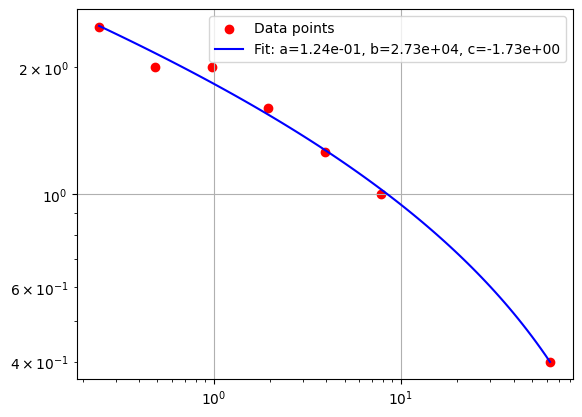

In [14]:
# learning rate - minimize()

n_parallel = np.array([128, 1024, 2048, 4096, 8192, 16384, 32768])/1000
utd = 1/n_parallel * 8
learning_rate = np.array([4e-5, 1e-4, 1.26e-4, 1.6e-4, 2e-4, 2e-4, 2.5e-4]) * 10000

optim_f = power_law_with_const_min
current_params = [-2.50000000e+00,  4.75000000e+00,  1e-04]
print(optim_f(current_params, utd, learning_rate))
lbfgs_pred = scipy.optimize.minimize(optim_f, current_params, args=((utd,), learning_rate), method='L-BFGS-B', tol=1e-10).x
# print(lbfgs_pred)
print(optim_f(lbfgs_pred, utd, learning_rate), 'loss')

# Plot the fit
x_smooth = np.logspace(np.log10(np.min(utd)), np.log10(np.max(utd)), 100)
y_fitted = power_law_with_const(x_smooth, *lbfgs_pred)

plt.figure()
plt.scatter(utd, learning_rate, color='red', label='Data points')
plt.plot(x_smooth, y_fitted, 'b-', label=f'Fit: a={lbfgs_pred[0]:.2e}, b={lbfgs_pred[1]:.2e}, c={lbfgs_pred[2]:.2e}')
print(f'y = {lbfgs_pred[2]:.2e} + (x/{lbfgs_pred[1]:.2e})^-{lbfgs_pred[0]:.2e}')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()



  6%|▋         | 8/125 [00:00<00:03, 36.07it/s]/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """
 26%|██▋       | 33/125 [00:00<00:01, 47.86it/s]/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in power
  import sys
100%|██████████| 125/125 [00:02<00:00, 52.97it/s]


0.002654084755498555 loss
y = -1.30e+00 + (x/2.80e+03)^-1.43e-01


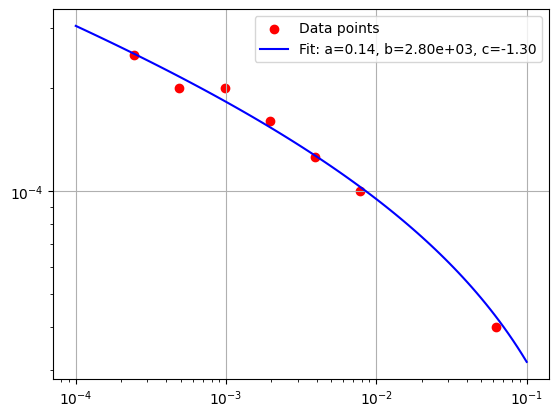

In [21]:
# learning rate - fit()

n_parallel = np.array([128, 1024, 2048, 4096, 8192, 16384, 32768])
utd = 1/n_parallel * 8
learning_rate = np.array([4e-5, 1e-4, 1.26e-4, 1.6e-4, 2e-4, 2e-4, 2.5e-4])
fit_data_points = [1, 2, 3, 4, 5, 6]

rescaling = [1000, 10000]
fitted_params = fit(utd[fit_data_points] * rescaling[0], learning_rate[fit_data_points] * rescaling[1], power_law_with_const_min,
                     [slice(-4, 4, 1.6),slice(1, 10, 2),slice(1e-5, 5e-4, 1e-4)], disp=False, maxiter=100)
print(power_law_with_const_min(fitted_params, utd[fit_data_points] * rescaling[0], learning_rate[fit_data_points] * rescaling[1]), 'loss')

x_smooth = np.logspace(-1, 2, 100)
a, b, c = fitted_params
y_fitted = power_law_with_const(x_smooth, a, b, c)

plt.scatter(utd, learning_rate, color='red', label='Data points')
plt.plot(x_smooth / rescaling[0], y_fitted / rescaling[1], 'b-', label=f'Fit: a={a:.2f}, b={b:.2e}, c={c:.2f}')
print(f'y = {c:.2e} + (x/{b:.2e})^-{a:.2e}')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()



/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log
  # Remove the CWD from sys.path while we load stuff.
/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log
  # Remove the CWD from sys.path while we load stuff.
/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log
  # Remove the CWD from sys.path while we load stuff.
/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log
  # Remove the CWD from sys.path while we load stuff.
/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log
  # Remove the CWD from sys.path while we load stuff.
/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/sit

loss 0.41987349469597063
y = 2.00e+00 / (1 + x/1.09e-05)^-8.00e-01


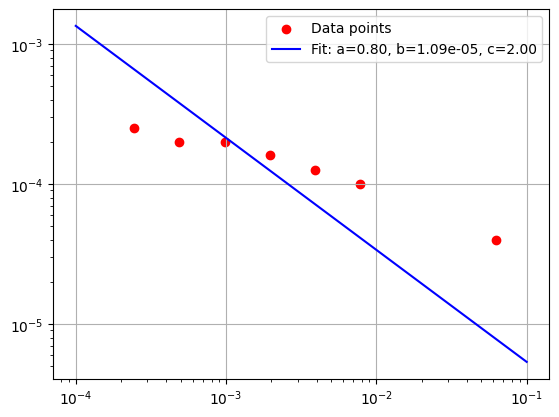

In [30]:
# large-batch training - log space - fit()

def lr_rule_min(args, *params):
    x,y = params
    a,b,c = args
    return ((log_lr_rule(x,a,b,c) - np.log(y)) ** 2).mean()
    # return ((np.log(lr_rule(x,a,b,c) / y)) ** 2).mean()

def log_lr_rule(x, a, b, c):
    return np.log(c) - a * np.log(1 + x/b)

n_parallel = np.array([128, 1024, 2048, 4096, 8192, 16384, 32768])
utd = 1/n_parallel * 8
learning_rate = np.array([4e-5, 1e-4, 1.26e-4, 1.6e-4, 2e-4, 2e-4, 2.5e-4])
fit_data_points = [1, 2, 3, 4, 5, 6]

scaling = [1000, 1]
fitted_params = fit(utd[fit_data_points] * scaling[0], learning_rate[fit_data_points] * scaling[1], lr_rule_min,
                     [slice(-4, 4, 1.6),slice(1e-5, 5e-4, 1e-4),slice(-10, 10, 4)], maxiter=100)
print('loss', lr_rule_min(fitted_params, utd[fit_data_points] * scaling[0], learning_rate[fit_data_points] * scaling[1]))
a, b, c = fitted_params
x_smooth = np.logspace(-1, 2, 100)
y_fitted = np.exp(log_lr_rule(x_smooth, a, b, c))

plt.scatter(utd, learning_rate, color='red', label='Data points')
plt.plot(x_smooth / scaling[0], y_fitted / scaling[1], 'b-', label=f'Fit: a={a:.2f}, b={b:.2e}, c={c:.2f}')
print(f'y = {c:.2e} / (1 + x/{b:.2e})^-{a:.2e}')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()

In [18]:
daily_prob = 1e-2
total_days = 8 * 365 / 3
total_prob = 1 - (1 - daily_prob) ** total_days
total_prob


0.9999435596876843